In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0,
    'binarize'      : True,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_1_0_e_e_0_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_0


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4106669, 828)
(4106669, 7)
validation
(632885, 828)
(632885, 7)
test
(473305, 828)
(473305, 7)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 2048)              1697792   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 7)                 903       


Total params: 4485895 (17.11 MB)


Trainable params: 4485895 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/42 [..............................] - ETA: 8:54 - loss: 2.0077 - STD: 0.0470 - MAE: 0.2454

 2/42 [>.............................] - ETA: 18s - loss: 1.9637 - STD: 0.0464 - MAE: 0.2435 

 3/42 [=>............................] - ETA: 17s - loss: 1.9544 - STD: 0.0534 - MAE: 0.2423

 4/42 [=>............................] - ETA: 17s - loss: 1.9518 - STD: 0.0557 - MAE: 0.2418

 5/42 [==>...........................] - ETA: 17s - loss: 1.9496 - STD: 0.0556 - MAE: 0.2417

 6/42 [===>..........................] - ETA: 16s - loss: 1.9463 - STD: 0.0544 - MAE: 0.2417

 7/42 [====>.........................] - ETA: 15s - loss: 1.9424 - STD: 0.0527 - MAE: 0.2417

 8/42 [====>.........................] - ETA: 15s - loss: 1.9389 - STD: 0.0511 - MAE: 0.2417

 9/42 [=====>........................] - ETA: 14s - loss: 1.9364 - STD: 0.0497 - MAE: 0.2417

10/42 [======>.......................] - ETA: 14s - loss: 1.9347 - STD: 0.0486 - MAE: 0.2418

11/42 [======>.......................] - ETA: 13s - loss: 1.9337 - STD: 0.0476 - MAE: 0.2418

12/42 [=======>......................] - ETA: 13s - loss: 1.9330 - STD: 0.0466 - MAE: 0.2419

13/42 [========>.....................] - ETA: 13s - loss: 1.9321 - STD: 0.0456 - MAE: 0.2419

14/42 [=========>....................] - ETA: 13s - loss: 1.9310 - STD: 0.0447 - MAE: 0.2420

15/42 [=========>....................] - ETA: 12s - loss: 1.9298 - STD: 0.0440 - MAE: 0.2420

16/42 [==========>...................] - ETA: 12s - loss: 1.9287 - STD: 0.0435 - MAE: 0.2420

17/42 [===========>..................] - ETA: 11s - loss: 1.9278 - STD: 0.0433 - MAE: 0.2420

18/42 [===========>..................] - ETA: 11s - loss: 1.9270 - STD: 0.0433 - MAE: 0.2419

19/42 [============>.................] - ETA: 10s - loss: 1.9262 - STD: 0.0435 - MAE: 0.2419

20/42 [=============>................] - ETA: 10s - loss: 1.9254 - STD: 0.0436 - MAE: 0.2419

21/42 [==============>...............] - ETA: 9s - loss: 1.9246 - STD: 0.0437 - MAE: 0.2418 

22/42 [==============>...............] - ETA: 9s - loss: 1.9237 - STD: 0.0437 - MAE: 0.2418

23/42 [===============>..............] - ETA: 8s - loss: 1.9225 - STD: 0.0436 - MAE: 0.2417

24/42 [================>.............] - ETA: 8s - loss: 1.9213 - STD: 0.0435 - MAE: 0.2417

25/42 [================>.............] - ETA: 7s - loss: 1.9198 - STD: 0.0433 - MAE: 0.2416

26/42 [=================>............] - ETA: 7s - loss: 1.9181 - STD: 0.0431 - MAE: 0.2416

27/42 [==================>...........] - ETA: 7s - loss: 1.9161 - STD: 0.0430 - MAE: 0.2415

28/42 [===================>..........] - ETA: 6s - loss: 1.9139 - STD: 0.0429 - MAE: 0.2414

29/42 [===================>..........] - ETA: 6s - loss: 1.9113 - STD: 0.0431 - MAE: 0.2412

30/42 [====================>.........] - ETA: 5s - loss: 1.9084 - STD: 0.0435 - MAE: 0.2410

31/42 [=====================>........] - ETA: 5s - loss: 1.9051 - STD: 0.0441 - MAE: 0.2408

32/42 [=====================>........] - ETA: 4s - loss: 1.9016 - STD: 0.0449 - MAE: 0.2406

33/42 [======================>.......] - ETA: 4s - loss: 1.8980 - STD: 0.0458 - MAE: 0.2403

34/42 [=======================>......] - ETA: 3s - loss: 1.8942 - STD: 0.0467 - MAE: 0.2400

35/42 [========================>.....] - ETA: 3s - loss: 1.8940 - STD: 0.0477 - MAE: 0.2397

36/42 [========================>.....] - ETA: 3s - loss: 1.8899 - STD: 0.0485 - MAE: 0.2395

37/42 [=========================>....] - ETA: 2s - loss: 1.8856 - STD: 0.0494 - MAE: 0.2392

38/42 [==========================>...] - ETA: 2s - loss: 1.8813 - STD: 0.0502 - MAE: 0.2389

39/42 [==========================>...] - ETA: 1s - loss: 1.8771 - STD: 0.0510 - MAE: 0.2386

40/42 [===========================>..] - ETA: 1s - loss: 1.8726 - STD: 0.0520 - MAE: 0.2383

41/42 [============================>.] - ETA: 0s - loss: 1.8684 - STD: 0.0530 - MAE: 0.2379

42/42 [==============================] - ETA: 0s - loss: 1.8642 - STD: 0.0540 - MAE: 0.2376

42/42 [==============================] - 40s 664ms/step - loss: 1.8642 - STD: 0.0540 - MAE: 0.2376 - val_loss: 1.6875 - val_STD: 0.0918 - val_MAE: 0.2245


Epoch 2/10000


 1/42 [..............................] - ETA: 39s - loss: 1.6882 - STD: 0.0946 - MAE: 0.2238

 2/42 [>.............................] - ETA: 26s - loss: 1.6845 - STD: 0.0950 - MAE: 0.2236

 3/42 [=>............................] - ETA: 21s - loss: 1.6811 - STD: 0.0950 - MAE: 0.2234

 4/42 [=>............................] - ETA: 20s - loss: 1.6793 - STD: 0.0957 - MAE: 0.2231

 5/42 [==>...........................] - ETA: 21s - loss: 1.6756 - STD: 0.0973 - MAE: 0.2226

 6/42 [===>..........................] - ETA: 19s - loss: 1.6722 - STD: 0.0989 - MAE: 0.2221

 7/42 [====>.........................] - ETA: 19s - loss: 1.6692 - STD: 0.1001 - MAE: 0.2216

 8/42 [====>.........................] - ETA: 18s - loss: 1.6663 - STD: 0.1013 - MAE: 0.2212

 9/42 [=====>........................] - ETA: 18s - loss: 1.6637 - STD: 0.1023 - MAE: 0.2208

10/42 [======>.......................] - ETA: 17s - loss: 1.6611 - STD: 0.1031 - MAE: 0.2205

11/42 [======>.......................] - ETA: 16s - loss: 1.6583 - STD: 0.1040 - MAE: 0.2201

12/42 [=======>......................] - ETA: 15s - loss: 1.6550 - STD: 0.1052 - MAE: 0.2197

13/42 [========>.....................] - ETA: 15s - loss: 1.6517 - STD: 0.1062 - MAE: 0.2193

15/42 [=========>....................] - ETA: 13s - loss: 1.6479 - STD: 0.1079 - MAE: 0.2186

16/42 [==========>...................] - ETA: 12s - loss: 1.6450 - STD: 0.1086 - MAE: 0.2183

17/42 [===========>..................] - ETA: 12s - loss: 1.6418 - STD: 0.1096 - MAE: 0.2180

18/42 [===========>..................] - ETA: 12s - loss: 1.6386 - STD: 0.1103 - MAE: 0.2177

19/42 [============>.................] - ETA: 11s - loss: 1.6353 - STD: 0.1110 - MAE: 0.2173

20/42 [=============>................] - ETA: 10s - loss: 1.6323 - STD: 0.1118 - MAE: 0.2171

21/42 [==============>...............] - ETA: 10s - loss: 1.6291 - STD: 0.1123 - MAE: 0.2168

22/42 [==============>...............] - ETA: 10s - loss: 1.6267 - STD: 0.1134 - MAE: 0.2165

23/42 [===============>..............] - ETA: 9s - loss: 1.6245 - STD: 0.1136 - MAE: 0.2163 

24/42 [================>.............] - ETA: 9s - loss: 1.6213 - STD: 0.1141 - MAE: 0.2161

25/42 [================>.............] - ETA: 8s - loss: 1.6184 - STD: 0.1150 - MAE: 0.2158

26/42 [=================>............] - ETA: 7s - loss: 1.6161 - STD: 0.1154 - MAE: 0.2156

27/42 [==================>...........] - ETA: 7s - loss: 1.6129 - STD: 0.1160 - MAE: 0.2153

28/42 [===================>..........] - ETA: 6s - loss: 1.6099 - STD: 0.1165 - MAE: 0.2151

29/42 [===================>..........] - ETA: 6s - loss: 1.6069 - STD: 0.1169 - MAE: 0.2149

30/42 [====================>.........] - ETA: 5s - loss: 1.6032 - STD: 0.1175 - MAE: 0.2146

31/42 [=====================>........] - ETA: 5s - loss: 1.5998 - STD: 0.1181 - MAE: 0.2143

32/42 [=====================>........] - ETA: 4s - loss: 1.5961 - STD: 0.1185 - MAE: 0.2140

33/42 [======================>.......] - ETA: 4s - loss: 1.5922 - STD: 0.1189 - MAE: 0.2138

34/42 [=======================>......] - ETA: 3s - loss: 1.5883 - STD: 0.1196 - MAE: 0.2134

35/42 [========================>.....] - ETA: 3s - loss: 1.5840 - STD: 0.1201 - MAE: 0.2131

36/42 [========================>.....] - ETA: 2s - loss: 1.5798 - STD: 0.1205 - MAE: 0.2129

37/42 [=========================>....] - ETA: 2s - loss: 1.5754 - STD: 0.1211 - MAE: 0.2125

38/42 [==========================>...] - ETA: 1s - loss: 1.5707 - STD: 0.1216 - MAE: 0.2122

39/42 [==========================>...] - ETA: 1s - loss: 1.5660 - STD: 0.1221 - MAE: 0.2119

40/42 [===========================>..] - ETA: 1s - loss: 1.5617 - STD: 0.1228 - MAE: 0.2115

41/42 [============================>.] - ETA: 0s - loss: 1.5579 - STD: 0.1234 - MAE: 0.2112

42/42 [==============================] - ETA: 0s - loss: 1.5551 - STD: 0.1240 - MAE: 0.2109

42/42 [==============================] - 25s 581ms/step - loss: 1.5551 - STD: 0.1240 - MAE: 0.2109 - val_loss: 1.4550 - val_STD: 0.1572 - val_MAE: 0.1980


Epoch 3/10000


 1/42 [..............................] - ETA: 44s - loss: 1.3719 - STD: 0.1577 - MAE: 0.1941

 2/42 [>.............................] - ETA: 21s - loss: 1.3819 - STD: 0.1561 - MAE: 0.1950

 3/42 [=>............................] - ETA: 18s - loss: 1.3818 - STD: 0.1547 - MAE: 0.1953

 4/42 [=>............................] - ETA: 19s - loss: 1.3715 - STD: 0.1551 - MAE: 0.1947

 5/42 [==>...........................] - ETA: 18s - loss: 1.3715 - STD: 0.1562 - MAE: 0.1943

 6/42 [===>..........................] - ETA: 17s - loss: 1.3641 - STD: 0.1570 - MAE: 0.1937

 7/42 [====>.........................] - ETA: 17s - loss: 1.3638 - STD: 0.1570 - MAE: 0.1937

 8/42 [====>.........................] - ETA: 16s - loss: 1.3589 - STD: 0.1571 - MAE: 0.1935

 9/42 [=====>........................] - ETA: 16s - loss: 1.3559 - STD: 0.1578 - MAE: 0.1931

10/42 [======>.......................] - ETA: 15s - loss: 1.3518 - STD: 0.1584 - MAE: 0.1927

11/42 [======>.......................] - ETA: 15s - loss: 1.3491 - STD: 0.1584 - MAE: 0.1926

12/42 [=======>......................] - ETA: 14s - loss: 1.3459 - STD: 0.1585 - MAE: 0.1924

13/42 [========>.....................] - ETA: 14s - loss: 1.3435 - STD: 0.1591 - MAE: 0.1921

14/42 [=========>....................] - ETA: 13s - loss: 1.3408 - STD: 0.1596 - MAE: 0.1918

15/42 [=========>....................] - ETA: 13s - loss: 1.3386 - STD: 0.1597 - MAE: 0.1917

16/42 [==========>...................] - ETA: 12s - loss: 1.3365 - STD: 0.1599 - MAE: 0.1915

17/42 [===========>..................] - ETA: 12s - loss: 1.3344 - STD: 0.1604 - MAE: 0.1913

18/42 [===========>..................] - ETA: 11s - loss: 1.3325 - STD: 0.1608 - MAE: 0.1911

19/42 [============>.................] - ETA: 11s - loss: 1.3303 - STD: 0.1610 - MAE: 0.1909

20/42 [=============>................] - ETA: 10s - loss: 1.3285 - STD: 0.1612 - MAE: 0.1907

21/42 [==============>...............] - ETA: 10s - loss: 1.3262 - STD: 0.1615 - MAE: 0.1905

22/42 [==============>...............] - ETA: 9s - loss: 1.3244 - STD: 0.1618 - MAE: 0.1903 

23/42 [===============>..............] - ETA: 9s - loss: 1.3225 - STD: 0.1620 - MAE: 0.1901

25/42 [================>.............] - ETA: 8s - loss: 1.3204 - STD: 0.1624 - MAE: 0.1898

26/42 [=================>............] - ETA: 7s - loss: 1.3188 - STD: 0.1628 - MAE: 0.1896

27/42 [==================>...........] - ETA: 7s - loss: 1.3170 - STD: 0.1630 - MAE: 0.1895

28/42 [===================>..........] - ETA: 7s - loss: 1.3153 - STD: 0.1631 - MAE: 0.1893

29/42 [===================>..........] - ETA: 6s - loss: 1.3138 - STD: 0.1634 - MAE: 0.1892

30/42 [====================>.........] - ETA: 6s - loss: 1.3122 - STD: 0.1636 - MAE: 0.1890

31/42 [=====================>........] - ETA: 5s - loss: 1.3107 - STD: 0.1638 - MAE: 0.1889

32/42 [=====================>........] - ETA: 5s - loss: 1.3093 - STD: 0.1639 - MAE: 0.1888

33/42 [======================>.......] - ETA: 4s - loss: 1.3080 - STD: 0.1641 - MAE: 0.1886

34/42 [=======================>......] - ETA: 4s - loss: 1.3065 - STD: 0.1643 - MAE: 0.1885

35/42 [========================>.....] - ETA: 3s - loss: 1.3052 - STD: 0.1645 - MAE: 0.1884

36/42 [========================>.....] - ETA: 3s - loss: 1.3039 - STD: 0.1646 - MAE: 0.1883

37/42 [=========================>....] - ETA: 2s - loss: 1.3027 - STD: 0.1649 - MAE: 0.1881

38/42 [==========================>...] - ETA: 2s - loss: 1.3013 - STD: 0.1650 - MAE: 0.1880

39/42 [==========================>...] - ETA: 1s - loss: 1.3001 - STD: 0.1652 - MAE: 0.1879

40/42 [===========================>..] - ETA: 1s - loss: 1.2989 - STD: 0.1654 - MAE: 0.1878

41/42 [============================>.] - ETA: 0s - loss: 1.2978 - STD: 0.1656 - MAE: 0.1877

42/42 [==============================] - ETA: 0s - loss: 1.2967 - STD: 0.1658 - MAE: 0.1876

42/42 [==============================] - 25s 581ms/step - loss: 1.2967 - STD: 0.1658 - MAE: 0.1876 - val_loss: 1.3023 - val_STD: 0.1712 - val_MAE: 0.1862


Epoch 4/10000


 1/42 [..............................] - ETA: 45s - loss: 1.2444 - STD: 0.1731 - MAE: 0.1825

 2/42 [>.............................] - ETA: 18s - loss: 1.2451 - STD: 0.1740 - MAE: 0.1822

 3/42 [=>............................] - ETA: 11s - loss: 1.2458 - STD: 0.1740 - MAE: 0.1826

 4/42 [=>............................] - ETA: 14s - loss: 1.2468 - STD: 0.1739 - MAE: 0.1826

 5/42 [==>...........................] - ETA: 15s - loss: 1.2476 - STD: 0.1742 - MAE: 0.1825

 6/42 [===>..........................] - ETA: 16s - loss: 1.2464 - STD: 0.1742 - MAE: 0.1824

 7/42 [====>.........................] - ETA: 16s - loss: 1.2468 - STD: 0.1740 - MAE: 0.1824

 8/42 [====>.........................] - ETA: 16s - loss: 1.2462 - STD: 0.1741 - MAE: 0.1823

 9/42 [=====>........................] - ETA: 16s - loss: 1.2459 - STD: 0.1744 - MAE: 0.1822

10/42 [======>.......................] - ETA: 15s - loss: 1.2460 - STD: 0.1743 - MAE: 0.1822

11/42 [======>.......................] - ETA: 15s - loss: 1.2453 - STD: 0.1745 - MAE: 0.1821

12/42 [=======>......................] - ETA: 15s - loss: 1.2451 - STD: 0.1747 - MAE: 0.1820

13/42 [========>.....................] - ETA: 14s - loss: 1.2451 - STD: 0.1748 - MAE: 0.1820

14/42 [=========>....................] - ETA: 14s - loss: 1.2454 - STD: 0.1748 - MAE: 0.1820

15/42 [=========>....................] - ETA: 13s - loss: 1.2459 - STD: 0.1752 - MAE: 0.1819

16/42 [==========>...................] - ETA: 13s - loss: 1.2469 - STD: 0.1752 - MAE: 0.1819

17/42 [===========>..................] - ETA: 13s - loss: 1.2471 - STD: 0.1754 - MAE: 0.1818

18/42 [===========>..................] - ETA: 12s - loss: 1.2466 - STD: 0.1755 - MAE: 0.1818

19/42 [============>.................] - ETA: 11s - loss: 1.2458 - STD: 0.1755 - MAE: 0.1817

20/42 [=============>................] - ETA: 11s - loss: 1.2456 - STD: 0.1756 - MAE: 0.1817

21/42 [==============>...............] - ETA: 11s - loss: 1.2453 - STD: 0.1756 - MAE: 0.1817

22/42 [==============>...............] - ETA: 10s - loss: 1.2447 - STD: 0.1756 - MAE: 0.1816

23/42 [===============>..............] - ETA: 10s - loss: 1.2441 - STD: 0.1757 - MAE: 0.1816

24/42 [================>.............] - ETA: 9s - loss: 1.2435 - STD: 0.1757 - MAE: 0.1815 

25/42 [================>.............] - ETA: 8s - loss: 1.2433 - STD: 0.1758 - MAE: 0.1814

26/42 [=================>............] - ETA: 8s - loss: 1.2428 - STD: 0.1758 - MAE: 0.1814

27/42 [==================>...........] - ETA: 7s - loss: 1.2422 - STD: 0.1759 - MAE: 0.1813

28/42 [===================>..........] - ETA: 7s - loss: 1.2417 - STD: 0.1760 - MAE: 0.1813

29/42 [===================>..........] - ETA: 6s - loss: 1.2412 - STD: 0.1761 - MAE: 0.1812

30/42 [====================>.........] - ETA: 6s - loss: 1.2406 - STD: 0.1762 - MAE: 0.1812

31/42 [=====================>........] - ETA: 5s - loss: 1.2401 - STD: 0.1763 - MAE: 0.1811

32/42 [=====================>........] - ETA: 5s - loss: 1.2396 - STD: 0.1763 - MAE: 0.1811

33/42 [======================>.......] - ETA: 4s - loss: 1.2391 - STD: 0.1764 - MAE: 0.1810

34/42 [=======================>......] - ETA: 4s - loss: 1.2387 - STD: 0.1765 - MAE: 0.1810

35/42 [========================>.....] - ETA: 3s - loss: 1.2382 - STD: 0.1765 - MAE: 0.1809

36/42 [========================>.....] - ETA: 3s - loss: 1.2377 - STD: 0.1766 - MAE: 0.1809

37/42 [=========================>....] - ETA: 2s - loss: 1.2372 - STD: 0.1767 - MAE: 0.1808

38/42 [==========================>...] - ETA: 2s - loss: 1.2366 - STD: 0.1767 - MAE: 0.1808

39/42 [==========================>...] - ETA: 1s - loss: 1.2360 - STD: 0.1768 - MAE: 0.1807

40/42 [===========================>..] - ETA: 1s - loss: 1.2356 - STD: 0.1769 - MAE: 0.1807

41/42 [============================>.] - ETA: 0s - loss: 1.2351 - STD: 0.1769 - MAE: 0.1806

42/42 [==============================] - ETA: 0s - loss: 1.2344 - STD: 0.1770 - MAE: 0.1805

42/42 [==============================] - 25s 584ms/step - loss: 1.2344 - STD: 0.1770 - MAE: 0.1805 - val_loss: 1.2731 - val_STD: 0.1796 - val_MAE: 0.1817


Epoch 5/10000


 1/42 [..............................] - ETA: 42s - loss: 1.2134 - STD: 0.1816 - MAE: 0.1778

 2/42 [>.............................] - ETA: 18s - loss: 1.2156 - STD: 0.1809 - MAE: 0.1780

 3/42 [=>............................] - ETA: 16s - loss: 1.2150 - STD: 0.1810 - MAE: 0.1780

 4/42 [=>............................] - ETA: 17s - loss: 1.2164 - STD: 0.1808 - MAE: 0.1781

 5/42 [==>...........................] - ETA: 17s - loss: 1.2172 - STD: 0.1811 - MAE: 0.1781

 6/42 [===>..........................] - ETA: 18s - loss: 1.2182 - STD: 0.1808 - MAE: 0.1782

 7/42 [====>.........................] - ETA: 18s - loss: 1.2173 - STD: 0.1811 - MAE: 0.1780

 8/42 [====>.........................] - ETA: 17s - loss: 1.2165 - STD: 0.1809 - MAE: 0.1781

 9/42 [=====>........................] - ETA: 17s - loss: 1.2154 - STD: 0.1809 - MAE: 0.1780

10/42 [======>.......................] - ETA: 16s - loss: 1.2151 - STD: 0.1809 - MAE: 0.1780

11/42 [======>.......................] - ETA: 15s - loss: 1.2147 - STD: 0.1809 - MAE: 0.1779

12/42 [=======>......................] - ETA: 14s - loss: 1.2151 - STD: 0.1811 - MAE: 0.1779

13/42 [========>.....................] - ETA: 14s - loss: 1.2152 - STD: 0.1809 - MAE: 0.1779

14/42 [=========>....................] - ETA: 13s - loss: 1.2157 - STD: 0.1812 - MAE: 0.1778

16/42 [==========>...................] - ETA: 11s - loss: 1.2151 - STD: 0.1814 - MAE: 0.1777

17/42 [===========>..................] - ETA: 11s - loss: 1.2143 - STD: 0.1814 - MAE: 0.1777

18/42 [===========>..................] - ETA: 10s - loss: 1.2135 - STD: 0.1814 - MAE: 0.1776

19/42 [============>.................] - ETA: 10s - loss: 1.2132 - STD: 0.1816 - MAE: 0.1775

20/42 [=============>................] - ETA: 9s - loss: 1.2125 - STD: 0.1815 - MAE: 0.1775 

21/42 [==============>...............] - ETA: 9s - loss: 1.2117 - STD: 0.1815 - MAE: 0.1775

22/42 [==============>...............] - ETA: 8s - loss: 1.2108 - STD: 0.1816 - MAE: 0.1774

23/42 [===============>..............] - ETA: 8s - loss: 1.2102 - STD: 0.1816 - MAE: 0.1773

24/42 [================>.............] - ETA: 8s - loss: 1.2097 - STD: 0.1818 - MAE: 0.1772

25/42 [================>.............] - ETA: 7s - loss: 1.2093 - STD: 0.1818 - MAE: 0.1772

26/42 [=================>............] - ETA: 7s - loss: 1.2087 - STD: 0.1819 - MAE: 0.1771

27/42 [==================>...........] - ETA: 6s - loss: 1.2079 - STD: 0.1821 - MAE: 0.1770

28/42 [===================>..........] - ETA: 6s - loss: 1.2073 - STD: 0.1820 - MAE: 0.1770

29/42 [===================>..........] - ETA: 6s - loss: 1.2064 - STD: 0.1821 - MAE: 0.1769

30/42 [====================>.........] - ETA: 5s - loss: 1.2057 - STD: 0.1822 - MAE: 0.1768

31/42 [=====================>........] - ETA: 5s - loss: 1.2049 - STD: 0.1822 - MAE: 0.1768

32/42 [=====================>........] - ETA: 4s - loss: 1.2044 - STD: 0.1823 - MAE: 0.1767

33/42 [======================>.......] - ETA: 4s - loss: 1.2037 - STD: 0.1824 - MAE: 0.1766

34/42 [=======================>......] - ETA: 3s - loss: 1.2028 - STD: 0.1826 - MAE: 0.1765

35/42 [========================>.....] - ETA: 3s - loss: 1.2022 - STD: 0.1826 - MAE: 0.1764

36/42 [========================>.....] - ETA: 2s - loss: 1.2015 - STD: 0.1828 - MAE: 0.1763

37/42 [=========================>....] - ETA: 2s - loss: 1.2008 - STD: 0.1829 - MAE: 0.1762

38/42 [==========================>...] - ETA: 1s - loss: 1.2004 - STD: 0.1829 - MAE: 0.1762

39/42 [==========================>...] - ETA: 1s - loss: 1.1997 - STD: 0.1831 - MAE: 0.1761

40/42 [===========================>..] - ETA: 0s - loss: 1.1990 - STD: 0.1832 - MAE: 0.1760

41/42 [============================>.] - ETA: 0s - loss: 1.1984 - STD: 0.1833 - MAE: 0.1759

42/42 [==============================] - ETA: 0s - loss: 1.1977 - STD: 0.1834 - MAE: 0.1758

42/42 [==============================] - 23s 541ms/step - loss: 1.1977 - STD: 0.1834 - MAE: 0.1758 - val_loss: 1.2140 - val_STD: 0.1856 - val_MAE: 0.1755


Epoch 6/10000


 1/42 [..............................] - ETA: 32s - loss: 1.1674 - STD: 0.1867 - MAE: 0.1724

 2/42 [>.............................] - ETA: 16s - loss: 1.1669 - STD: 0.1881 - MAE: 0.1719

 3/42 [=>............................] - ETA: 16s - loss: 1.1679 - STD: 0.1885 - MAE: 0.1718

 4/42 [=>............................] - ETA: 15s - loss: 1.1689 - STD: 0.1889 - MAE: 0.1717

 5/42 [==>...........................] - ETA: 15s - loss: 1.1716 - STD: 0.1892 - MAE: 0.1717

 6/42 [===>..........................] - ETA: 15s - loss: 1.1773 - STD: 0.1895 - MAE: 0.1718

 7/42 [====>.........................] - ETA: 14s - loss: 1.1854 - STD: 0.1895 - MAE: 0.1723

 8/42 [====>.........................] - ETA: 14s - loss: 1.1866 - STD: 0.1899 - MAE: 0.1722

 9/42 [=====>........................] - ETA: 14s - loss: 1.1840 - STD: 0.1898 - MAE: 0.1721

10/42 [======>.......................] - ETA: 13s - loss: 1.1833 - STD: 0.1901 - MAE: 0.1719

11/42 [======>.......................] - ETA: 13s - loss: 1.1837 - STD: 0.1900 - MAE: 0.1720

12/42 [=======>......................] - ETA: 12s - loss: 1.1831 - STD: 0.1902 - MAE: 0.1719

13/42 [========>.....................] - ETA: 12s - loss: 1.1821 - STD: 0.1901 - MAE: 0.1719

14/42 [=========>....................] - ETA: 11s - loss: 1.1814 - STD: 0.1902 - MAE: 0.1718

15/42 [=========>....................] - ETA: 11s - loss: 1.1814 - STD: 0.1901 - MAE: 0.1718

16/42 [==========>...................] - ETA: 11s - loss: 1.1798 - STD: 0.1903 - MAE: 0.1717

17/42 [===========>..................] - ETA: 10s - loss: 1.1785 - STD: 0.1904 - MAE: 0.1715

18/42 [===========>..................] - ETA: 10s - loss: 1.1777 - STD: 0.1904 - MAE: 0.1715

19/42 [============>.................] - ETA: 10s - loss: 1.1761 - STD: 0.1906 - MAE: 0.1713

20/42 [=============>................] - ETA: 9s - loss: 1.1754 - STD: 0.1907 - MAE: 0.1713 

21/42 [==============>...............] - ETA: 9s - loss: 1.1747 - STD: 0.1908 - MAE: 0.1712

22/42 [==============>...............] - ETA: 8s - loss: 1.1733 - STD: 0.1909 - MAE: 0.1711

23/42 [===============>..............] - ETA: 8s - loss: 1.1726 - STD: 0.1910 - MAE: 0.1710

25/42 [================>.............] - ETA: 7s - loss: 1.1719 - STD: 0.1911 - MAE: 0.1709

26/42 [=================>............] - ETA: 7s - loss: 1.1711 - STD: 0.1912 - MAE: 0.1708

27/42 [==================>...........] - ETA: 6s - loss: 1.1704 - STD: 0.1912 - MAE: 0.1708

28/42 [===================>..........] - ETA: 6s - loss: 1.1697 - STD: 0.1913 - MAE: 0.1707

29/42 [===================>..........] - ETA: 5s - loss: 1.1685 - STD: 0.1913 - MAE: 0.1706

30/42 [====================>.........] - ETA: 5s - loss: 1.1676 - STD: 0.1914 - MAE: 0.1705

31/42 [=====================>........] - ETA: 4s - loss: 1.1664 - STD: 0.1915 - MAE: 0.1704

32/42 [=====================>........] - ETA: 4s - loss: 1.1653 - STD: 0.1915 - MAE: 0.1704

33/42 [======================>.......] - ETA: 4s - loss: 1.1644 - STD: 0.1916 - MAE: 0.1703

34/42 [=======================>......] - ETA: 3s - loss: 1.1634 - STD: 0.1916 - MAE: 0.1702

35/42 [========================>.....] - ETA: 3s - loss: 1.1626 - STD: 0.1918 - MAE: 0.1701

36/42 [========================>.....] - ETA: 2s - loss: 1.1616 - STD: 0.1918 - MAE: 0.1700

37/42 [=========================>....] - ETA: 2s - loss: 1.1606 - STD: 0.1919 - MAE: 0.1699

38/42 [==========================>...] - ETA: 1s - loss: 1.1597 - STD: 0.1920 - MAE: 0.1698

39/42 [==========================>...] - ETA: 1s - loss: 1.1589 - STD: 0.1921 - MAE: 0.1698

40/42 [===========================>..] - ETA: 0s - loss: 1.1582 - STD: 0.1922 - MAE: 0.1697

41/42 [============================>.] - ETA: 0s - loss: 1.1577 - STD: 0.1922 - MAE: 0.1696

42/42 [==============================] - ETA: 0s - loss: 1.1577 - STD: 0.1924 - MAE: 0.1696

42/42 [==============================] - 22s 508ms/step - loss: 1.1577 - STD: 0.1924 - MAE: 0.1696 - val_loss: 1.2331 - val_STD: 0.1923 - val_MAE: 0.1745


Epoch 7/10000


 1/42 [..............................] - ETA: 41s - loss: 1.1698 - STD: 0.1936 - MAE: 0.1699

 2/42 [>.............................] - ETA: 16s - loss: 1.1523 - STD: 0.1960 - MAE: 0.1679

 3/42 [=>............................] - ETA: 16s - loss: 1.1439 - STD: 0.1960 - MAE: 0.1674

 4/42 [=>............................] - ETA: 15s - loss: 1.1393 - STD: 0.1957 - MAE: 0.1672

 5/42 [==>...........................] - ETA: 16s - loss: 1.1398 - STD: 0.1962 - MAE: 0.1670

 6/42 [===>..........................] - ETA: 15s - loss: 1.1409 - STD: 0.1956 - MAE: 0.1672

 7/42 [====>.........................] - ETA: 16s - loss: 1.1389 - STD: 0.1958 - MAE: 0.1671

 8/42 [====>.........................] - ETA: 15s - loss: 1.1369 - STD: 0.1957 - MAE: 0.1670

 9/42 [=====>........................] - ETA: 15s - loss: 1.1343 - STD: 0.1957 - MAE: 0.1668

10/42 [======>.......................] - ETA: 15s - loss: 1.1330 - STD: 0.1959 - MAE: 0.1667

11/42 [======>.......................] - ETA: 14s - loss: 1.1324 - STD: 0.1959 - MAE: 0.1666

12/42 [=======>......................] - ETA: 14s - loss: 1.1315 - STD: 0.1962 - MAE: 0.1664

13/42 [========>.....................] - ETA: 13s - loss: 1.1304 - STD: 0.1962 - MAE: 0.1664

14/42 [=========>....................] - ETA: 13s - loss: 1.1289 - STD: 0.1963 - MAE: 0.1662

15/42 [=========>....................] - ETA: 12s - loss: 1.1280 - STD: 0.1964 - MAE: 0.1662

16/42 [==========>...................] - ETA: 12s - loss: 1.1273 - STD: 0.1964 - MAE: 0.1661

17/42 [===========>..................] - ETA: 11s - loss: 1.1265 - STD: 0.1965 - MAE: 0.1660

18/42 [===========>..................] - ETA: 11s - loss: 1.1258 - STD: 0.1965 - MAE: 0.1660

19/42 [============>.................] - ETA: 10s - loss: 1.1249 - STD: 0.1967 - MAE: 0.1659

20/42 [=============>................] - ETA: 10s - loss: 1.1239 - STD: 0.1967 - MAE: 0.1658

21/42 [==============>...............] - ETA: 9s - loss: 1.1235 - STD: 0.1969 - MAE: 0.1656 

22/42 [==============>...............] - ETA: 9s - loss: 1.1232 - STD: 0.1969 - MAE: 0.1657

23/42 [===============>..............] - ETA: 8s - loss: 1.1227 - STD: 0.1970 - MAE: 0.1656

24/42 [================>.............] - ETA: 8s - loss: 1.1221 - STD: 0.1970 - MAE: 0.1655

25/42 [================>.............] - ETA: 7s - loss: 1.1211 - STD: 0.1971 - MAE: 0.1655

26/42 [=================>............] - ETA: 7s - loss: 1.1205 - STD: 0.1972 - MAE: 0.1654

28/42 [===================>..........] - ETA: 6s - loss: 1.1204 - STD: 0.1974 - MAE: 0.1653

29/42 [===================>..........] - ETA: 5s - loss: 1.1207 - STD: 0.1974 - MAE: 0.1653

30/42 [====================>.........] - ETA: 5s - loss: 1.1210 - STD: 0.1975 - MAE: 0.1653

31/42 [=====================>........] - ETA: 4s - loss: 1.1233 - STD: 0.1975 - MAE: 0.1654

32/42 [=====================>........] - ETA: 4s - loss: 1.1273 - STD: 0.1977 - MAE: 0.1655

33/42 [======================>.......] - ETA: 3s - loss: 1.1300 - STD: 0.1977 - MAE: 0.1657

34/42 [=======================>......] - ETA: 3s - loss: 1.1291 - STD: 0.1978 - MAE: 0.1656

35/42 [========================>.....] - ETA: 3s - loss: 1.1306 - STD: 0.1980 - MAE: 0.1656

36/42 [========================>.....] - ETA: 2s - loss: 1.1317 - STD: 0.1980 - MAE: 0.1657

37/42 [=========================>....] - ETA: 2s - loss: 1.1314 - STD: 0.1981 - MAE: 0.1656

38/42 [==========================>...] - ETA: 1s - loss: 1.1322 - STD: 0.1982 - MAE: 0.1656

39/42 [==========================>...] - ETA: 1s - loss: 1.1319 - STD: 0.1982 - MAE: 0.1656

40/42 [===========================>..] - ETA: 0s - loss: 1.1316 - STD: 0.1982 - MAE: 0.1656

41/42 [============================>.] - ETA: 0s - loss: 1.1316 - STD: 0.1982 - MAE: 0.1656

42/42 [==============================] - ETA: 0s - loss: 1.1313 - STD: 0.1982 - MAE: 0.1656

42/42 [==============================] - 22s 502ms/step - loss: 1.1313 - STD: 0.1982 - MAE: 0.1656 - val_loss: 1.1972 - val_STD: 0.1971 - val_MAE: 0.1699


Epoch 8/10000


 1/42 [..............................] - ETA: 30s - loss: 1.1223 - STD: 0.1997 - MAE: 0.1648

 2/42 [>.............................] - ETA: 22s - loss: 1.1264 - STD: 0.1984 - MAE: 0.1657

 3/42 [=>............................] - ETA: 22s - loss: 1.1187 - STD: 0.1976 - MAE: 0.1655

 4/42 [=>............................] - ETA: 20s - loss: 1.1194 - STD: 0.1986 - MAE: 0.1651

 5/42 [==>...........................] - ETA: 19s - loss: 1.1177 - STD: 0.1984 - MAE: 0.1650

 6/42 [===>..........................] - ETA: 18s - loss: 1.1150 - STD: 0.1984 - MAE: 0.1649

 7/42 [====>.........................] - ETA: 17s - loss: 1.1138 - STD: 0.1983 - MAE: 0.1648

 8/42 [====>.........................] - ETA: 17s - loss: 1.1109 - STD: 0.1982 - MAE: 0.1646

 9/42 [=====>........................] - ETA: 16s - loss: 1.1100 - STD: 0.1985 - MAE: 0.1644

10/42 [======>.......................] - ETA: 15s - loss: 1.1083 - STD: 0.1986 - MAE: 0.1643

11/42 [======>.......................] - ETA: 15s - loss: 1.1072 - STD: 0.1987 - MAE: 0.1642

12/42 [=======>......................] - ETA: 14s - loss: 1.1060 - STD: 0.1988 - MAE: 0.1640

13/42 [========>.....................] - ETA: 14s - loss: 1.1050 - STD: 0.1990 - MAE: 0.1639

14/42 [=========>....................] - ETA: 13s - loss: 1.1042 - STD: 0.1992 - MAE: 0.1638

15/42 [=========>....................] - ETA: 13s - loss: 1.1034 - STD: 0.1993 - MAE: 0.1636

16/42 [==========>...................] - ETA: 12s - loss: 1.1019 - STD: 0.1995 - MAE: 0.1635

17/42 [===========>..................] - ETA: 12s - loss: 1.1012 - STD: 0.1996 - MAE: 0.1634

18/42 [===========>..................] - ETA: 11s - loss: 1.1004 - STD: 0.1997 - MAE: 0.1633

19/42 [============>.................] - ETA: 11s - loss: 1.0996 - STD: 0.1998 - MAE: 0.1632

21/42 [==============>...............] - ETA: 9s - loss: 1.0988 - STD: 0.1999 - MAE: 0.1631 

22/42 [==============>...............] - ETA: 9s - loss: 1.0978 - STD: 0.1999 - MAE: 0.1630

23/42 [===============>..............] - ETA: 8s - loss: 1.0972 - STD: 0.2000 - MAE: 0.1629

24/42 [================>.............] - ETA: 8s - loss: 1.0964 - STD: 0.2001 - MAE: 0.1629

25/42 [================>.............] - ETA: 8s - loss: 1.0956 - STD: 0.2002 - MAE: 0.1628

26/42 [=================>............] - ETA: 7s - loss: 1.0951 - STD: 0.2003 - MAE: 0.1627

27/42 [==================>...........] - ETA: 7s - loss: 1.0944 - STD: 0.2004 - MAE: 0.1626

28/42 [===================>..........] - ETA: 6s - loss: 1.0937 - STD: 0.2005 - MAE: 0.1625

29/42 [===================>..........] - ETA: 6s - loss: 1.0932 - STD: 0.2006 - MAE: 0.1625

30/42 [====================>.........] - ETA: 5s - loss: 1.0928 - STD: 0.2007 - MAE: 0.1624

31/42 [=====================>........] - ETA: 5s - loss: 1.0922 - STD: 0.2008 - MAE: 0.1623

32/42 [=====================>........] - ETA: 4s - loss: 1.0915 - STD: 0.2008 - MAE: 0.1623

33/42 [======================>.......] - ETA: 4s - loss: 1.0910 - STD: 0.2009 - MAE: 0.1622

34/42 [=======================>......] - ETA: 3s - loss: 1.0905 - STD: 0.2010 - MAE: 0.1621

35/42 [========================>.....] - ETA: 3s - loss: 1.0900 - STD: 0.2012 - MAE: 0.1620

36/42 [========================>.....] - ETA: 2s - loss: 1.0896 - STD: 0.2012 - MAE: 0.1620

37/42 [=========================>....] - ETA: 2s - loss: 1.0892 - STD: 0.2013 - MAE: 0.1619

38/42 [==========================>...] - ETA: 1s - loss: 1.0890 - STD: 0.2013 - MAE: 0.1619

39/42 [==========================>...] - ETA: 1s - loss: 1.0888 - STD: 0.2014 - MAE: 0.1619

40/42 [===========================>..] - ETA: 0s - loss: 1.0887 - STD: 0.2014 - MAE: 0.1619

41/42 [============================>.] - ETA: 0s - loss: 1.0890 - STD: 0.2015 - MAE: 0.1618

42/42 [==============================] - ETA: 0s - loss: 1.0897 - STD: 0.2016 - MAE: 0.1618

42/42 [==============================] - 22s 517ms/step - loss: 1.0897 - STD: 0.2016 - MAE: 0.1618 - val_loss: 1.1967 - val_STD: 0.2050 - val_MAE: 0.1675


Epoch 9/10000


 1/42 [..............................] - ETA: 37s - loss: 1.1141 - STD: 0.2068 - MAE: 0.1610

 2/42 [>.............................] - ETA: 17s - loss: 1.1026 - STD: 0.2048 - MAE: 0.1611

 3/42 [=>............................] - ETA: 16s - loss: 1.0909 - STD: 0.2050 - MAE: 0.1604

 4/42 [=>............................] - ETA: 16s - loss: 1.0866 - STD: 0.2049 - MAE: 0.1602

 5/42 [==>...........................] - ETA: 15s - loss: 1.0878 - STD: 0.2045 - MAE: 0.1605

 6/42 [===>..........................] - ETA: 15s - loss: 1.0894 - STD: 0.2047 - MAE: 0.1605

 7/42 [====>.........................] - ETA: 15s - loss: 1.0877 - STD: 0.2044 - MAE: 0.1605

 8/42 [====>.........................] - ETA: 14s - loss: 1.0845 - STD: 0.2045 - MAE: 0.1603

 9/42 [=====>........................] - ETA: 14s - loss: 1.0823 - STD: 0.2045 - MAE: 0.1601

10/42 [======>.......................] - ETA: 14s - loss: 1.0811 - STD: 0.2045 - MAE: 0.1601

11/42 [======>.......................] - ETA: 13s - loss: 1.0799 - STD: 0.2047 - MAE: 0.1599

12/42 [=======>......................] - ETA: 13s - loss: 1.0786 - STD: 0.2047 - MAE: 0.1599

13/42 [========>.....................] - ETA: 12s - loss: 1.0774 - STD: 0.2048 - MAE: 0.1597

14/42 [=========>....................] - ETA: 12s - loss: 1.0769 - STD: 0.2049 - MAE: 0.1597

15/42 [=========>....................] - ETA: 11s - loss: 1.0760 - STD: 0.2049 - MAE: 0.1596

16/42 [==========>...................] - ETA: 11s - loss: 1.0752 - STD: 0.2050 - MAE: 0.1596

17/42 [===========>..................] - ETA: 10s - loss: 1.0740 - STD: 0.2050 - MAE: 0.1595

18/42 [===========>..................] - ETA: 10s - loss: 1.0729 - STD: 0.2051 - MAE: 0.1594

19/42 [============>.................] - ETA: 10s - loss: 1.0721 - STD: 0.2052 - MAE: 0.1593

20/42 [=============>................] - ETA: 9s - loss: 1.0712 - STD: 0.2053 - MAE: 0.1592 

22/42 [==============>...............] - ETA: 8s - loss: 1.0701 - STD: 0.2055 - MAE: 0.1590

23/42 [===============>..............] - ETA: 8s - loss: 1.0695 - STD: 0.2056 - MAE: 0.1589

24/42 [================>.............] - ETA: 7s - loss: 1.0687 - STD: 0.2056 - MAE: 0.1589

25/42 [================>.............] - ETA: 7s - loss: 1.0682 - STD: 0.2057 - MAE: 0.1588

26/42 [=================>............] - ETA: 6s - loss: 1.0679 - STD: 0.2057 - MAE: 0.1587

27/42 [==================>...........] - ETA: 6s - loss: 1.0675 - STD: 0.2058 - MAE: 0.1587

28/42 [===================>..........] - ETA: 6s - loss: 1.0671 - STD: 0.2059 - MAE: 0.1587

29/42 [===================>..........] - ETA: 5s - loss: 1.0672 - STD: 0.2059 - MAE: 0.1587

30/42 [====================>.........] - ETA: 5s - loss: 1.0679 - STD: 0.2060 - MAE: 0.1586

31/42 [=====================>........] - ETA: 4s - loss: 1.0695 - STD: 0.2060 - MAE: 0.1587

32/42 [=====================>........] - ETA: 4s - loss: 1.0704 - STD: 0.2062 - MAE: 0.1587

33/42 [======================>.......] - ETA: 3s - loss: 1.0706 - STD: 0.2062 - MAE: 0.1587

34/42 [=======================>......] - ETA: 3s - loss: 1.0704 - STD: 0.2062 - MAE: 0.1587

35/42 [========================>.....] - ETA: 3s - loss: 1.0709 - STD: 0.2063 - MAE: 0.1587

36/42 [========================>.....] - ETA: 2s - loss: 1.0719 - STD: 0.2062 - MAE: 0.1588

37/42 [=========================>....] - ETA: 2s - loss: 1.0715 - STD: 0.2062 - MAE: 0.1588

38/42 [==========================>...] - ETA: 1s - loss: 1.0714 - STD: 0.2063 - MAE: 0.1588

39/42 [==========================>...] - ETA: 1s - loss: 1.0719 - STD: 0.2062 - MAE: 0.1588

40/42 [===========================>..] - ETA: 0s - loss: 1.0715 - STD: 0.2062 - MAE: 0.1588

41/42 [============================>.] - ETA: 0s - loss: 1.0712 - STD: 0.2062 - MAE: 0.1588

42/42 [==============================] - ETA: 0s - loss: 1.0712 - STD: 0.2061 - MAE: 0.1588

42/42 [==============================] - 22s 510ms/step - loss: 1.0712 - STD: 0.2061 - MAE: 0.1588 - val_loss: 1.1500 - val_STD: 0.2043 - val_MAE: 0.1647


Epoch 10/10000


 1/42 [..............................] - ETA: 32s - loss: 1.0589 - STD: 0.2072 - MAE: 0.1577

 2/42 [>.............................] - ETA: 17s - loss: 1.0586 - STD: 0.2063 - MAE: 0.1583

 3/42 [=>............................] - ETA: 16s - loss: 1.0558 - STD: 0.2057 - MAE: 0.1583

 4/42 [=>............................] - ETA: 17s - loss: 1.0547 - STD: 0.2064 - MAE: 0.1579

 5/42 [==>...........................] - ETA: 16s - loss: 1.0544 - STD: 0.2067 - MAE: 0.1578

 6/42 [===>..........................] - ETA: 17s - loss: 1.0529 - STD: 0.2069 - MAE: 0.1576

 7/42 [====>.........................] - ETA: 16s - loss: 1.0534 - STD: 0.2077 - MAE: 0.1573

 8/42 [====>.........................] - ETA: 16s - loss: 1.0533 - STD: 0.2078 - MAE: 0.1573

 9/42 [=====>........................] - ETA: 16s - loss: 1.0525 - STD: 0.2080 - MAE: 0.1571

10/42 [======>.......................] - ETA: 15s - loss: 1.0542 - STD: 0.2084 - MAE: 0.1570

11/42 [======>.......................] - ETA: 14s - loss: 1.0575 - STD: 0.2082 - MAE: 0.1573

12/42 [=======>......................] - ETA: 14s - loss: 1.0642 - STD: 0.2083 - MAE: 0.1576

13/42 [========>.....................] - ETA: 14s - loss: 1.0702 - STD: 0.2083 - MAE: 0.1579

14/42 [=========>....................] - ETA: 13s - loss: 1.0729 - STD: 0.2081 - MAE: 0.1582

15/42 [=========>....................] - ETA: 13s - loss: 1.0715 - STD: 0.2081 - MAE: 0.1581

16/42 [==========>...................] - ETA: 12s - loss: 1.0703 - STD: 0.2082 - MAE: 0.1580

17/42 [===========>..................] - ETA: 12s - loss: 1.0713 - STD: 0.2080 - MAE: 0.1581

18/42 [===========>..................] - ETA: 11s - loss: 1.0706 - STD: 0.2080 - MAE: 0.1581

19/42 [============>.................] - ETA: 11s - loss: 1.0693 - STD: 0.2080 - MAE: 0.1580

20/42 [=============>................] - ETA: 10s - loss: 1.0692 - STD: 0.2079 - MAE: 0.1581

21/42 [==============>...............] - ETA: 10s - loss: 1.0688 - STD: 0.2079 - MAE: 0.1580

22/42 [==============>...............] - ETA: 9s - loss: 1.0677 - STD: 0.2078 - MAE: 0.1580 

23/42 [===============>..............] - ETA: 9s - loss: 1.0669 - STD: 0.2078 - MAE: 0.1579

24/42 [================>.............] - ETA: 8s - loss: 1.0666 - STD: 0.2079 - MAE: 0.1579

25/42 [================>.............] - ETA: 8s - loss: 1.0656 - STD: 0.2079 - MAE: 0.1578

26/42 [=================>............] - ETA: 7s - loss: 1.0649 - STD: 0.2079 - MAE: 0.1578

27/42 [==================>...........] - ETA: 7s - loss: 1.0644 - STD: 0.2079 - MAE: 0.1577

28/42 [===================>..........] - ETA: 6s - loss: 1.0636 - STD: 0.2079 - MAE: 0.1577

29/42 [===================>..........] - ETA: 6s - loss: 1.0628 - STD: 0.2079 - MAE: 0.1576

30/42 [====================>.........] - ETA: 5s - loss: 1.0621 - STD: 0.2079 - MAE: 0.1576

31/42 [=====================>........] - ETA: 5s - loss: 1.0621 - STD: 0.2080 - MAE: 0.1575

32/42 [=====================>........] - ETA: 4s - loss: 1.0613 - STD: 0.2080 - MAE: 0.1575

33/42 [======================>.......] - ETA: 4s - loss: 1.0606 - STD: 0.2081 - MAE: 0.1574

34/42 [=======================>......] - ETA: 3s - loss: 1.0599 - STD: 0.2081 - MAE: 0.1574

35/42 [========================>.....] - ETA: 3s - loss: 1.0593 - STD: 0.2082 - MAE: 0.1573

36/42 [========================>.....] - ETA: 2s - loss: 1.0586 - STD: 0.2083 - MAE: 0.1572

37/42 [=========================>....] - ETA: 2s - loss: 1.0580 - STD: 0.2083 - MAE: 0.1572

38/42 [==========================>...] - ETA: 1s - loss: 1.0573 - STD: 0.2083 - MAE: 0.1571

39/42 [==========================>...] - ETA: 1s - loss: 1.0566 - STD: 0.2084 - MAE: 0.1571

40/42 [===========================>..] - ETA: 0s - loss: 1.0560 - STD: 0.2084 - MAE: 0.1570

41/42 [============================>.] - ETA: 0s - loss: 1.0556 - STD: 0.2085 - MAE: 0.1570

42/42 [==============================] - ETA: 0s - loss: 1.0552 - STD: 0.2085 - MAE: 0.1569

42/42 [==============================] - 24s 557ms/step - loss: 1.0552 - STD: 0.2085 - MAE: 0.1569 - val_loss: 1.1272 - val_STD: 0.2084 - val_MAE: 0.1617


Epoch 11/10000


 1/42 [..............................] - ETA: 38s - loss: 1.0380 - STD: 0.2119 - MAE: 0.1545

 2/42 [>.............................] - ETA: 22s - loss: 1.0376 - STD: 0.2115 - MAE: 0.1546

 3/42 [=>............................] - ETA: 23s - loss: 1.0363 - STD: 0.2113 - MAE: 0.1546

 4/42 [=>............................] - ETA: 20s - loss: 1.0346 - STD: 0.2113 - MAE: 0.1545

 5/42 [==>...........................] - ETA: 20s - loss: 1.0335 - STD: 0.2110 - MAE: 0.1546

 6/42 [===>..........................] - ETA: 19s - loss: 1.0320 - STD: 0.2109 - MAE: 0.1545

 7/42 [====>.........................] - ETA: 18s - loss: 1.0319 - STD: 0.2109 - MAE: 0.1545

 8/42 [====>.........................] - ETA: 17s - loss: 1.0315 - STD: 0.2109 - MAE: 0.1545

 9/42 [=====>........................] - ETA: 16s - loss: 1.0322 - STD: 0.2110 - MAE: 0.1545

10/42 [======>.......................] - ETA: 15s - loss: 1.0329 - STD: 0.2110 - MAE: 0.1545

11/42 [======>.......................] - ETA: 14s - loss: 1.0333 - STD: 0.2111 - MAE: 0.1545

12/42 [=======>......................] - ETA: 14s - loss: 1.0337 - STD: 0.2113 - MAE: 0.1545

13/42 [========>.....................] - ETA: 13s - loss: 1.0342 - STD: 0.2112 - MAE: 0.1545

14/42 [=========>....................] - ETA: 13s - loss: 1.0338 - STD: 0.2113 - MAE: 0.1545

15/42 [=========>....................] - ETA: 13s - loss: 1.0333 - STD: 0.2112 - MAE: 0.1545

16/42 [==========>...................] - ETA: 12s - loss: 1.0326 - STD: 0.2112 - MAE: 0.1544

17/42 [===========>..................] - ETA: 11s - loss: 1.0321 - STD: 0.2113 - MAE: 0.1544

18/42 [===========>..................] - ETA: 11s - loss: 1.0319 - STD: 0.2112 - MAE: 0.1544

19/42 [============>.................] - ETA: 11s - loss: 1.0316 - STD: 0.2113 - MAE: 0.1543

20/42 [=============>................] - ETA: 10s - loss: 1.0312 - STD: 0.2113 - MAE: 0.1543

21/42 [==============>...............] - ETA: 10s - loss: 1.0306 - STD: 0.2113 - MAE: 0.1543

22/42 [==============>...............] - ETA: 9s - loss: 1.0302 - STD: 0.2114 - MAE: 0.1543 

23/42 [===============>..............] - ETA: 9s - loss: 1.0304 - STD: 0.2113 - MAE: 0.1543

24/42 [================>.............] - ETA: 8s - loss: 1.0311 - STD: 0.2114 - MAE: 0.1543

25/42 [================>.............] - ETA: 8s - loss: 1.0329 - STD: 0.2114 - MAE: 0.1544

26/42 [=================>............] - ETA: 7s - loss: 1.0360 - STD: 0.2114 - MAE: 0.1546

27/42 [==================>...........] - ETA: 7s - loss: 1.0397 - STD: 0.2115 - MAE: 0.1547

28/42 [===================>..........] - ETA: 6s - loss: 1.0422 - STD: 0.2114 - MAE: 0.1549

29/42 [===================>..........] - ETA: 6s - loss: 1.0426 - STD: 0.2115 - MAE: 0.1549

30/42 [====================>.........] - ETA: 5s - loss: 1.0432 - STD: 0.2114 - MAE: 0.1550

31/42 [=====================>........] - ETA: 5s - loss: 1.0438 - STD: 0.2114 - MAE: 0.1550

32/42 [=====================>........] - ETA: 4s - loss: 1.0436 - STD: 0.2114 - MAE: 0.1550

33/42 [======================>.......] - ETA: 4s - loss: 1.0433 - STD: 0.2113 - MAE: 0.1550

34/42 [=======================>......] - ETA: 3s - loss: 1.0434 - STD: 0.2114 - MAE: 0.1550

35/42 [========================>.....] - ETA: 3s - loss: 1.0433 - STD: 0.2113 - MAE: 0.1550

36/42 [========================>.....] - ETA: 2s - loss: 1.0426 - STD: 0.2113 - MAE: 0.1550

37/42 [=========================>....] - ETA: 2s - loss: 1.0423 - STD: 0.2112 - MAE: 0.1550

39/42 [==========================>...] - ETA: 1s - loss: 1.0417 - STD: 0.2111 - MAE: 0.1550

40/42 [===========================>..] - ETA: 0s - loss: 1.0416 - STD: 0.2111 - MAE: 0.1550

41/42 [============================>.] - ETA: 0s - loss: 1.0416 - STD: 0.2111 - MAE: 0.1550

42/42 [==============================] - ETA: 0s - loss: 1.0409 - STD: 0.2111 - MAE: 0.1550

42/42 [==============================] - 24s 566ms/step - loss: 1.0409 - STD: 0.2111 - MAE: 0.1550 - val_loss: 1.1075 - val_STD: 0.2079 - val_MAE: 0.1613


Epoch 12/10000


 1/42 [..............................] - ETA: 40s - loss: 1.0199 - STD: 0.2122 - MAE: 0.1534

 2/42 [>.............................] - ETA: 20s - loss: 1.0308 - STD: 0.2132 - MAE: 0.1537

 3/42 [=>............................] - ETA: 21s - loss: 1.0299 - STD: 0.2131 - MAE: 0.1537

 4/42 [=>............................] - ETA: 20s - loss: 1.0259 - STD: 0.2130 - MAE: 0.1534

 5/42 [==>...........................] - ETA: 20s - loss: 1.0242 - STD: 0.2132 - MAE: 0.1532

 6/42 [===>..........................] - ETA: 19s - loss: 1.0233 - STD: 0.2131 - MAE: 0.1532

 7/42 [====>.........................] - ETA: 18s - loss: 1.0215 - STD: 0.2130 - MAE: 0.1531

 8/42 [====>.........................] - ETA: 17s - loss: 1.0200 - STD: 0.2130 - MAE: 0.1530

 9/42 [=====>........................] - ETA: 17s - loss: 1.0201 - STD: 0.2128 - MAE: 0.1531

10/42 [======>.......................] - ETA: 16s - loss: 1.0195 - STD: 0.2128 - MAE: 0.1531

11/42 [======>.......................] - ETA: 16s - loss: 1.0189 - STD: 0.2129 - MAE: 0.1530

12/42 [=======>......................] - ETA: 15s - loss: 1.0193 - STD: 0.2129 - MAE: 0.1530

13/42 [========>.....................] - ETA: 14s - loss: 1.0192 - STD: 0.2131 - MAE: 0.1530

14/42 [=========>....................] - ETA: 14s - loss: 1.0188 - STD: 0.2131 - MAE: 0.1529

15/42 [=========>....................] - ETA: 13s - loss: 1.0185 - STD: 0.2132 - MAE: 0.1529

16/42 [==========>...................] - ETA: 13s - loss: 1.0186 - STD: 0.2133 - MAE: 0.1528

17/42 [===========>..................] - ETA: 12s - loss: 1.0186 - STD: 0.2132 - MAE: 0.1529

18/42 [===========>..................] - ETA: 11s - loss: 1.0187 - STD: 0.2133 - MAE: 0.1528

19/42 [============>.................] - ETA: 11s - loss: 1.0187 - STD: 0.2133 - MAE: 0.1528

20/42 [=============>................] - ETA: 10s - loss: 1.0186 - STD: 0.2133 - MAE: 0.1528

21/42 [==============>...............] - ETA: 10s - loss: 1.0185 - STD: 0.2133 - MAE: 0.1528

22/42 [==============>...............] - ETA: 9s - loss: 1.0183 - STD: 0.2133 - MAE: 0.1528 

23/42 [===============>..............] - ETA: 9s - loss: 1.0183 - STD: 0.2133 - MAE: 0.1528

24/42 [================>.............] - ETA: 8s - loss: 1.0182 - STD: 0.2134 - MAE: 0.1528

25/42 [================>.............] - ETA: 8s - loss: 1.0180 - STD: 0.2133 - MAE: 0.1528

27/42 [==================>...........] - ETA: 7s - loss: 1.0177 - STD: 0.2133 - MAE: 0.1528

28/42 [===================>..........] - ETA: 6s - loss: 1.0174 - STD: 0.2133 - MAE: 0.1528

29/42 [===================>..........] - ETA: 6s - loss: 1.0173 - STD: 0.2133 - MAE: 0.1528

30/42 [====================>.........] - ETA: 5s - loss: 1.0173 - STD: 0.2133 - MAE: 0.1528

31/42 [=====================>........] - ETA: 5s - loss: 1.0173 - STD: 0.2134 - MAE: 0.1527

32/42 [=====================>........] - ETA: 4s - loss: 1.0173 - STD: 0.2134 - MAE: 0.1527

33/42 [======================>.......] - ETA: 4s - loss: 1.0174 - STD: 0.2134 - MAE: 0.1527

34/42 [=======================>......] - ETA: 3s - loss: 1.0173 - STD: 0.2134 - MAE: 0.1527

35/42 [========================>.....] - ETA: 3s - loss: 1.0173 - STD: 0.2134 - MAE: 0.1527

36/42 [========================>.....] - ETA: 2s - loss: 1.0173 - STD: 0.2134 - MAE: 0.1527

37/42 [=========================>....] - ETA: 2s - loss: 1.0177 - STD: 0.2135 - MAE: 0.1527

38/42 [==========================>...] - ETA: 1s - loss: 1.0189 - STD: 0.2134 - MAE: 0.1528

39/42 [==========================>...] - ETA: 1s - loss: 1.0208 - STD: 0.2136 - MAE: 0.1529

40/42 [===========================>..] - ETA: 0s - loss: 1.0216 - STD: 0.2136 - MAE: 0.1529

41/42 [============================>.] - ETA: 0s - loss: 1.0218 - STD: 0.2137 - MAE: 0.1529

42/42 [==============================] - ETA: 0s - loss: 1.0225 - STD: 0.2137 - MAE: 0.1529

42/42 [==============================] - 23s 546ms/step - loss: 1.0225 - STD: 0.2137 - MAE: 0.1529 - val_loss: 1.1351 - val_STD: 0.2054 - val_MAE: 0.1626


Epoch 13/10000


 1/42 [..............................] - ETA: 42s - loss: 1.1137 - STD: 0.2092 - MAE: 0.1606

 2/42 [>.............................] - ETA: 20s - loss: 1.0620 - STD: 0.2115 - MAE: 0.1564

 3/42 [=>............................] - ETA: 17s - loss: 1.0507 - STD: 0.2121 - MAE: 0.1554

 4/42 [=>............................] - ETA: 20s - loss: 1.0566 - STD: 0.2107 - MAE: 0.1563

 5/42 [==>...........................] - ETA: 18s - loss: 1.0479 - STD: 0.2108 - MAE: 0.1558

 6/42 [===>..........................] - ETA: 18s - loss: 1.0469 - STD: 0.2113 - MAE: 0.1555

 7/42 [====>.........................] - ETA: 18s - loss: 1.0463 - STD: 0.2108 - MAE: 0.1557

 8/42 [====>.........................] - ETA: 17s - loss: 1.0425 - STD: 0.2107 - MAE: 0.1555

 9/42 [=====>........................] - ETA: 17s - loss: 1.0461 - STD: 0.2112 - MAE: 0.1555

10/42 [======>.......................] - ETA: 16s - loss: 1.0441 - STD: 0.2109 - MAE: 0.1555

11/42 [======>.......................] - ETA: 15s - loss: 1.0427 - STD: 0.2108 - MAE: 0.1554

12/42 [=======>......................] - ETA: 15s - loss: 1.0438 - STD: 0.2111 - MAE: 0.1553

13/42 [========>.....................] - ETA: 14s - loss: 1.0423 - STD: 0.2112 - MAE: 0.1553

14/42 [=========>....................] - ETA: 13s - loss: 1.0433 - STD: 0.2112 - MAE: 0.1553

15/42 [=========>....................] - ETA: 13s - loss: 1.0412 - STD: 0.2114 - MAE: 0.1551

16/42 [==========>...................] - ETA: 13s - loss: 1.0437 - STD: 0.2117 - MAE: 0.1552

17/42 [===========>..................] - ETA: 12s - loss: 1.0469 - STD: 0.2118 - MAE: 0.1554

18/42 [===========>..................] - ETA: 12s - loss: 1.0477 - STD: 0.2119 - MAE: 0.1554

19/42 [============>.................] - ETA: 11s - loss: 1.0517 - STD: 0.2122 - MAE: 0.1555

20/42 [=============>................] - ETA: 10s - loss: 1.0507 - STD: 0.2122 - MAE: 0.1554

21/42 [==============>...............] - ETA: 10s - loss: 1.0576 - STD: 0.2124 - MAE: 0.1557

22/42 [==============>...............] - ETA: 9s - loss: 1.0589 - STD: 0.2125 - MAE: 0.1558 

23/42 [===============>..............] - ETA: 9s - loss: 1.0613 - STD: 0.2127 - MAE: 0.1559

24/42 [================>.............] - ETA: 8s - loss: 1.0595 - STD: 0.2127 - MAE: 0.1557

25/42 [================>.............] - ETA: 8s - loss: 1.0603 - STD: 0.2126 - MAE: 0.1559

26/42 [=================>............] - ETA: 7s - loss: 1.0583 - STD: 0.2125 - MAE: 0.1558

27/42 [==================>...........] - ETA: 7s - loss: 1.0587 - STD: 0.2126 - MAE: 0.1558

29/42 [===================>..........] - ETA: 6s - loss: 1.0579 - STD: 0.2123 - MAE: 0.1558

30/42 [====================>.........] - ETA: 5s - loss: 1.0572 - STD: 0.2123 - MAE: 0.1558

31/42 [=====================>........] - ETA: 5s - loss: 1.0563 - STD: 0.2122 - MAE: 0.1558

32/42 [=====================>........] - ETA: 4s - loss: 1.0558 - STD: 0.2122 - MAE: 0.1558

33/42 [======================>.......] - ETA: 4s - loss: 1.0545 - STD: 0.2122 - MAE: 0.1557

34/42 [=======================>......] - ETA: 3s - loss: 1.0538 - STD: 0.2121 - MAE: 0.1557

35/42 [========================>.....] - ETA: 3s - loss: 1.0527 - STD: 0.2120 - MAE: 0.1557

36/42 [========================>.....] - ETA: 2s - loss: 1.0516 - STD: 0.2120 - MAE: 0.1556

37/42 [=========================>....] - ETA: 2s - loss: 1.0506 - STD: 0.2120 - MAE: 0.1556

38/42 [==========================>...] - ETA: 1s - loss: 1.0495 - STD: 0.2119 - MAE: 0.1555

39/42 [==========================>...] - ETA: 1s - loss: 1.0486 - STD: 0.2118 - MAE: 0.1555

40/42 [===========================>..] - ETA: 0s - loss: 1.0475 - STD: 0.2119 - MAE: 0.1554

41/42 [============================>.] - ETA: 0s - loss: 1.0466 - STD: 0.2118 - MAE: 0.1554

42/42 [==============================] - ETA: 0s - loss: 1.0457 - STD: 0.2118 - MAE: 0.1553

42/42 [==============================] - 23s 539ms/step - loss: 1.0457 - STD: 0.2118 - MAE: 0.1553 - val_loss: 1.0941 - val_STD: 0.2099 - val_MAE: 0.1591


Epoch 14/10000


 1/42 [..............................] - ETA: 37s - loss: 0.9966 - STD: 0.2139 - MAE: 0.1511

 2/42 [>.............................] - ETA: 19s - loss: 1.0024 - STD: 0.2136 - MAE: 0.1517

 3/42 [=>............................] - ETA: 17s - loss: 1.0020 - STD: 0.2135 - MAE: 0.1517

 4/42 [=>............................] - ETA: 19s - loss: 1.0023 - STD: 0.2135 - MAE: 0.1517

 5/42 [==>...........................] - ETA: 18s - loss: 1.0012 - STD: 0.2135 - MAE: 0.1517

 6/42 [===>..........................] - ETA: 17s - loss: 1.0007 - STD: 0.2135 - MAE: 0.1517

 7/42 [====>.........................] - ETA: 16s - loss: 1.0010 - STD: 0.2135 - MAE: 0.1517

 8/42 [====>.........................] - ETA: 16s - loss: 1.0007 - STD: 0.2135 - MAE: 0.1517

 9/42 [=====>........................] - ETA: 15s - loss: 1.0006 - STD: 0.2135 - MAE: 0.1517

10/42 [======>.......................] - ETA: 14s - loss: 0.9999 - STD: 0.2136 - MAE: 0.1516

11/42 [======>.......................] - ETA: 14s - loss: 0.9996 - STD: 0.2136 - MAE: 0.1516

12/42 [=======>......................] - ETA: 13s - loss: 0.9993 - STD: 0.2137 - MAE: 0.1515

13/42 [========>.....................] - ETA: 12s - loss: 0.9991 - STD: 0.2137 - MAE: 0.1515

14/42 [=========>....................] - ETA: 12s - loss: 0.9988 - STD: 0.2138 - MAE: 0.1515

15/42 [=========>....................] - ETA: 12s - loss: 0.9984 - STD: 0.2139 - MAE: 0.1514

16/42 [==========>...................] - ETA: 11s - loss: 0.9982 - STD: 0.2139 - MAE: 0.1514

17/42 [===========>..................] - ETA: 10s - loss: 0.9979 - STD: 0.2140 - MAE: 0.1513

18/42 [===========>..................] - ETA: 10s - loss: 0.9975 - STD: 0.2140 - MAE: 0.1513

19/42 [============>.................] - ETA: 10s - loss: 0.9971 - STD: 0.2141 - MAE: 0.1512

20/42 [=============>................] - ETA: 9s - loss: 0.9966 - STD: 0.2142 - MAE: 0.1512 

21/42 [==============>...............] - ETA: 9s - loss: 0.9962 - STD: 0.2142 - MAE: 0.1511

22/42 [==============>...............] - ETA: 8s - loss: 0.9961 - STD: 0.2143 - MAE: 0.1511

23/42 [===============>..............] - ETA: 8s - loss: 0.9960 - STD: 0.2144 - MAE: 0.1510

24/42 [================>.............] - ETA: 7s - loss: 0.9957 - STD: 0.2145 - MAE: 0.1510

25/42 [================>.............] - ETA: 7s - loss: 0.9955 - STD: 0.2145 - MAE: 0.1509

26/42 [=================>............] - ETA: 6s - loss: 0.9952 - STD: 0.2146 - MAE: 0.1509

27/42 [==================>...........] - ETA: 6s - loss: 0.9952 - STD: 0.2147 - MAE: 0.1508

28/42 [===================>..........] - ETA: 5s - loss: 0.9955 - STD: 0.2148 - MAE: 0.1508

29/42 [===================>..........] - ETA: 5s - loss: 0.9961 - STD: 0.2149 - MAE: 0.1508

30/42 [====================>.........] - ETA: 5s - loss: 0.9975 - STD: 0.2150 - MAE: 0.1509

31/42 [=====================>........] - ETA: 4s - loss: 0.9996 - STD: 0.2151 - MAE: 0.1510

32/42 [=====================>........] - ETA: 4s - loss: 1.0014 - STD: 0.2151 - MAE: 0.1511

33/42 [======================>.......] - ETA: 3s - loss: 1.0022 - STD: 0.2152 - MAE: 0.1511

34/42 [=======================>......] - ETA: 3s - loss: 1.0020 - STD: 0.2151 - MAE: 0.1511

35/42 [========================>.....] - ETA: 3s - loss: 1.0020 - STD: 0.2152 - MAE: 0.1511

36/42 [========================>.....] - ETA: 2s - loss: 1.0024 - STD: 0.2152 - MAE: 0.1511

38/42 [==========================>...] - ETA: 1s - loss: 1.0023 - STD: 0.2153 - MAE: 0.1511

39/42 [==========================>...] - ETA: 1s - loss: 1.0019 - STD: 0.2153 - MAE: 0.1510

40/42 [===========================>..] - ETA: 0s - loss: 1.0020 - STD: 0.2153 - MAE: 0.1510

41/42 [============================>.] - ETA: 0s - loss: 1.0021 - STD: 0.2154 - MAE: 0.1510

42/42 [==============================] - ETA: 0s - loss: 1.0020 - STD: 0.2154 - MAE: 0.1510

42/42 [==============================] - 21s 495ms/step - loss: 1.0020 - STD: 0.2154 - MAE: 0.1510 - val_loss: 1.0682 - val_STD: 0.2096 - val_MAE: 0.1578


Epoch 15/10000


 1/42 [..............................] - ETA: 31s - loss: 0.9867 - STD: 0.2137 - MAE: 0.1508

 2/42 [>.............................] - ETA: 15s - loss: 0.9928 - STD: 0.2151 - MAE: 0.1505

 3/42 [=>............................] - ETA: 16s - loss: 0.9932 - STD: 0.2148 - MAE: 0.1506

 4/42 [=>............................] - ETA: 16s - loss: 0.9921 - STD: 0.2149 - MAE: 0.1505

 5/42 [==>...........................] - ETA: 15s - loss: 0.9905 - STD: 0.2153 - MAE: 0.1503

 6/42 [===>..........................] - ETA: 15s - loss: 0.9909 - STD: 0.2154 - MAE: 0.1503

 7/42 [====>.........................] - ETA: 15s - loss: 0.9903 - STD: 0.2157 - MAE: 0.1501

 9/42 [=====>........................] - ETA: 12s - loss: 0.9889 - STD: 0.2161 - MAE: 0.1498

10/42 [======>.......................] - ETA: 12s - loss: 0.9884 - STD: 0.2162 - MAE: 0.1498

11/42 [======>.......................] - ETA: 12s - loss: 0.9885 - STD: 0.2163 - MAE: 0.1497

12/42 [=======>......................] - ETA: 12s - loss: 0.9885 - STD: 0.2163 - MAE: 0.1497

13/42 [========>.....................] - ETA: 12s - loss: 0.9881 - STD: 0.2164 - MAE: 0.1497

14/42 [=========>....................] - ETA: 11s - loss: 0.9878 - STD: 0.2165 - MAE: 0.1496

15/42 [=========>....................] - ETA: 11s - loss: 0.9874 - STD: 0.2165 - MAE: 0.1496

16/42 [==========>...................] - ETA: 11s - loss: 0.9872 - STD: 0.2167 - MAE: 0.1495

17/42 [===========>..................] - ETA: 10s - loss: 0.9865 - STD: 0.2168 - MAE: 0.1494

18/42 [===========>..................] - ETA: 10s - loss: 0.9863 - STD: 0.2168 - MAE: 0.1494

19/42 [============>.................] - ETA: 10s - loss: 0.9861 - STD: 0.2169 - MAE: 0.1493

20/42 [=============>................] - ETA: 9s - loss: 0.9861 - STD: 0.2169 - MAE: 0.1493 

21/42 [==============>...............] - ETA: 9s - loss: 0.9861 - STD: 0.2170 - MAE: 0.1493

22/42 [==============>...............] - ETA: 9s - loss: 0.9858 - STD: 0.2170 - MAE: 0.1493

23/42 [===============>..............] - ETA: 8s - loss: 0.9853 - STD: 0.2170 - MAE: 0.1492

24/42 [================>.............] - ETA: 8s - loss: 0.9851 - STD: 0.2171 - MAE: 0.1492

25/42 [================>.............] - ETA: 7s - loss: 0.9848 - STD: 0.2171 - MAE: 0.1492

26/42 [=================>............] - ETA: 7s - loss: 0.9846 - STD: 0.2171 - MAE: 0.1492

27/42 [==================>...........] - ETA: 6s - loss: 0.9844 - STD: 0.2171 - MAE: 0.1491

28/42 [===================>..........] - ETA: 6s - loss: 0.9845 - STD: 0.2172 - MAE: 0.1491

29/42 [===================>..........] - ETA: 6s - loss: 0.9853 - STD: 0.2172 - MAE: 0.1492

30/42 [====================>.........] - ETA: 5s - loss: 0.9869 - STD: 0.2173 - MAE: 0.1492

31/42 [=====================>........] - ETA: 5s - loss: 0.9890 - STD: 0.2173 - MAE: 0.1493

32/42 [=====================>........] - ETA: 4s - loss: 0.9906 - STD: 0.2174 - MAE: 0.1494

33/42 [======================>.......] - ETA: 4s - loss: 0.9912 - STD: 0.2173 - MAE: 0.1495

34/42 [=======================>......] - ETA: 3s - loss: 0.9909 - STD: 0.2174 - MAE: 0.1494

35/42 [========================>.....] - ETA: 3s - loss: 0.9908 - STD: 0.2174 - MAE: 0.1494

36/42 [========================>.....] - ETA: 2s - loss: 0.9914 - STD: 0.2173 - MAE: 0.1495

37/42 [=========================>....] - ETA: 2s - loss: 0.9917 - STD: 0.2174 - MAE: 0.1495

38/42 [==========================>...] - ETA: 1s - loss: 0.9916 - STD: 0.2174 - MAE: 0.1495

39/42 [==========================>...] - ETA: 1s - loss: 0.9912 - STD: 0.2174 - MAE: 0.1494

40/42 [===========================>..] - ETA: 0s - loss: 0.9914 - STD: 0.2175 - MAE: 0.1494

41/42 [============================>.] - ETA: 0s - loss: 0.9915 - STD: 0.2174 - MAE: 0.1495

42/42 [==============================] - ETA: 0s - loss: 0.9913 - STD: 0.2174 - MAE: 0.1495

42/42 [==============================] - 24s 575ms/step - loss: 0.9913 - STD: 0.2174 - MAE: 0.1495 - val_loss: 1.0651 - val_STD: 0.2121 - val_MAE: 0.1565


Epoch 16/10000


 1/42 [..............................] - ETA: 44s - loss: 0.9773 - STD: 0.2161 - MAE: 0.1492

 2/42 [>.............................] - ETA: 16s - loss: 0.9834 - STD: 0.2163 - MAE: 0.1495

 3/42 [=>............................] - ETA: 18s - loss: 0.9875 - STD: 0.2169 - MAE: 0.1495

 4/42 [=>............................] - ETA: 17s - loss: 0.9860 - STD: 0.2167 - MAE: 0.1495

 5/42 [==>...........................] - ETA: 17s - loss: 0.9830 - STD: 0.2170 - MAE: 0.1492

 6/42 [===>..........................] - ETA: 17s - loss: 0.9828 - STD: 0.2172 - MAE: 0.1490

 7/42 [====>.........................] - ETA: 16s - loss: 0.9830 - STD: 0.2173 - MAE: 0.1490

 8/42 [====>.........................] - ETA: 15s - loss: 0.9822 - STD: 0.2175 - MAE: 0.1489

 9/42 [=====>........................] - ETA: 16s - loss: 0.9808 - STD: 0.2176 - MAE: 0.1487

10/42 [======>.......................] - ETA: 15s - loss: 0.9801 - STD: 0.2177 - MAE: 0.1487

11/42 [======>.......................] - ETA: 15s - loss: 0.9799 - STD: 0.2178 - MAE: 0.1486

12/42 [=======>......................] - ETA: 14s - loss: 0.9795 - STD: 0.2178 - MAE: 0.1486

13/42 [========>.....................] - ETA: 14s - loss: 0.9785 - STD: 0.2179 - MAE: 0.1485

14/42 [=========>....................] - ETA: 13s - loss: 0.9781 - STD: 0.2180 - MAE: 0.1484

15/42 [=========>....................] - ETA: 13s - loss: 0.9778 - STD: 0.2181 - MAE: 0.1483

16/42 [==========>...................] - ETA: 13s - loss: 0.9778 - STD: 0.2182 - MAE: 0.1483

17/42 [===========>..................] - ETA: 12s - loss: 0.9775 - STD: 0.2183 - MAE: 0.1482

18/42 [===========>..................] - ETA: 12s - loss: 0.9772 - STD: 0.2184 - MAE: 0.1482

19/42 [============>.................] - ETA: 11s - loss: 0.9768 - STD: 0.2185 - MAE: 0.1481

20/42 [=============>................] - ETA: 11s - loss: 0.9763 - STD: 0.2185 - MAE: 0.1480

21/42 [==============>...............] - ETA: 10s - loss: 0.9760 - STD: 0.2186 - MAE: 0.1480

22/42 [==============>...............] - ETA: 10s - loss: 0.9758 - STD: 0.2186 - MAE: 0.1480

23/42 [===============>..............] - ETA: 9s - loss: 0.9757 - STD: 0.2186 - MAE: 0.1480 

24/42 [================>.............] - ETA: 9s - loss: 0.9759 - STD: 0.2187 - MAE: 0.1480

25/42 [================>.............] - ETA: 8s - loss: 0.9759 - STD: 0.2187 - MAE: 0.1479

26/42 [=================>............] - ETA: 8s - loss: 0.9760 - STD: 0.2187 - MAE: 0.1479

27/42 [==================>...........] - ETA: 7s - loss: 0.9762 - STD: 0.2188 - MAE: 0.1479

28/42 [===================>..........] - ETA: 7s - loss: 0.9761 - STD: 0.2188 - MAE: 0.1479

29/42 [===================>..........] - ETA: 6s - loss: 0.9763 - STD: 0.2188 - MAE: 0.1479

30/42 [====================>.........] - ETA: 6s - loss: 0.9763 - STD: 0.2189 - MAE: 0.1479

31/42 [=====================>........] - ETA: 5s - loss: 0.9762 - STD: 0.2189 - MAE: 0.1479

32/42 [=====================>........] - ETA: 5s - loss: 0.9761 - STD: 0.2189 - MAE: 0.1479

33/42 [======================>.......] - ETA: 4s - loss: 0.9761 - STD: 0.2189 - MAE: 0.1479

34/42 [=======================>......] - ETA: 4s - loss: 0.9767 - STD: 0.2190 - MAE: 0.1479

35/42 [========================>.....] - ETA: 3s - loss: 0.9773 - STD: 0.2190 - MAE: 0.1479

36/42 [========================>.....] - ETA: 3s - loss: 0.9781 - STD: 0.2191 - MAE: 0.1479

37/42 [=========================>....] - ETA: 2s - loss: 0.9788 - STD: 0.2191 - MAE: 0.1480

38/42 [==========================>...] - ETA: 2s - loss: 0.9789 - STD: 0.2192 - MAE: 0.1480

39/42 [==========================>...] - ETA: 1s - loss: 0.9787 - STD: 0.2192 - MAE: 0.1480

40/42 [===========================>..] - ETA: 1s - loss: 0.9783 - STD: 0.2192 - MAE: 0.1479

41/42 [============================>.] - ETA: 0s - loss: 0.9783 - STD: 0.2192 - MAE: 0.1479

42/42 [==============================] - 25s 584ms/step - loss: 0.9784 - STD: 0.2191 - MAE: 0.1480 - val_loss: 1.0713 - val_STD: 0.2154 - val_MAE: 0.1549


Epoch 17/10000


 1/42 [..............................] - ETA: 39s - loss: 1.0062 - STD: 0.2197 - MAE: 0.1497

 2/42 [>.............................] - ETA: 26s - loss: 1.0043 - STD: 0.2205 - MAE: 0.1492

 3/42 [=>............................] - ETA: 22s - loss: 1.0082 - STD: 0.2192 - MAE: 0.1499

 4/42 [=>............................] - ETA: 20s - loss: 1.0014 - STD: 0.2197 - MAE: 0.1493

 5/42 [==>...........................] - ETA: 19s - loss: 0.9958 - STD: 0.2193 - MAE: 0.1491

 6/42 [===>..........................] - ETA: 18s - loss: 0.9923 - STD: 0.2192 - MAE: 0.1489

 7/42 [====>.........................] - ETA: 17s - loss: 0.9905 - STD: 0.2191 - MAE: 0.1488

 8/42 [====>.........................] - ETA: 17s - loss: 0.9889 - STD: 0.2188 - MAE: 0.1488

 9/42 [=====>........................] - ETA: 15s - loss: 0.9887 - STD: 0.2188 - MAE: 0.1486

10/42 [======>.......................] - ETA: 14s - loss: 0.9863 - STD: 0.2187 - MAE: 0.1486

11/42 [======>.......................] - ETA: 14s - loss: 0.9845 - STD: 0.2188 - MAE: 0.1485

12/42 [=======>......................] - ETA: 14s - loss: 0.9835 - STD: 0.2188 - MAE: 0.1484

13/42 [========>.....................] - ETA: 13s - loss: 0.9819 - STD: 0.2188 - MAE: 0.1483

14/42 [=========>....................] - ETA: 13s - loss: 0.9805 - STD: 0.2190 - MAE: 0.1482

15/42 [=========>....................] - ETA: 13s - loss: 0.9792 - STD: 0.2190 - MAE: 0.1481

16/42 [==========>...................] - ETA: 12s - loss: 0.9785 - STD: 0.2191 - MAE: 0.1480

17/42 [===========>..................] - ETA: 12s - loss: 0.9781 - STD: 0.2193 - MAE: 0.1479

18/42 [===========>..................] - ETA: 11s - loss: 0.9792 - STD: 0.2193 - MAE: 0.1480

19/42 [============>.................] - ETA: 11s - loss: 0.9810 - STD: 0.2195 - MAE: 0.1480

20/42 [=============>................] - ETA: 10s - loss: 0.9829 - STD: 0.2196 - MAE: 0.1481

21/42 [==============>...............] - ETA: 10s - loss: 0.9849 - STD: 0.2197 - MAE: 0.1481

22/42 [==============>...............] - ETA: 9s - loss: 0.9852 - STD: 0.2198 - MAE: 0.1481 

23/42 [===============>..............] - ETA: 9s - loss: 0.9853 - STD: 0.2199 - MAE: 0.1481

24/42 [================>.............] - ETA: 8s - loss: 0.9851 - STD: 0.2200 - MAE: 0.1481

25/42 [================>.............] - ETA: 8s - loss: 0.9847 - STD: 0.2200 - MAE: 0.1480

26/42 [=================>............] - ETA: 7s - loss: 0.9838 - STD: 0.2200 - MAE: 0.1480

27/42 [==================>...........] - ETA: 7s - loss: 0.9836 - STD: 0.2200 - MAE: 0.1480

28/42 [===================>..........] - ETA: 6s - loss: 0.9842 - STD: 0.2200 - MAE: 0.1480

29/42 [===================>..........] - ETA: 6s - loss: 0.9843 - STD: 0.2199 - MAE: 0.1480

30/42 [====================>.........] - ETA: 5s - loss: 0.9840 - STD: 0.2199 - MAE: 0.1480

31/42 [=====================>........] - ETA: 5s - loss: 0.9836 - STD: 0.2199 - MAE: 0.1480

32/42 [=====================>........] - ETA: 4s - loss: 0.9831 - STD: 0.2199 - MAE: 0.1480

33/42 [======================>.......] - ETA: 4s - loss: 0.9831 - STD: 0.2199 - MAE: 0.1480

34/42 [=======================>......] - ETA: 4s - loss: 0.9827 - STD: 0.2199 - MAE: 0.1480

35/42 [========================>.....] - ETA: 3s - loss: 0.9821 - STD: 0.2199 - MAE: 0.1479

36/42 [========================>.....] - ETA: 3s - loss: 0.9816 - STD: 0.2198 - MAE: 0.1479

37/42 [=========================>....] - ETA: 2s - loss: 0.9811 - STD: 0.2198 - MAE: 0.1479

38/42 [==========================>...] - ETA: 2s - loss: 0.9805 - STD: 0.2198 - MAE: 0.1479

39/42 [==========================>...] - ETA: 1s - loss: 0.9801 - STD: 0.2198 - MAE: 0.1478

40/42 [===========================>..] - ETA: 1s - loss: 0.9796 - STD: 0.2198 - MAE: 0.1478

41/42 [============================>.] - ETA: 0s - loss: 0.9791 - STD: 0.2198 - MAE: 0.1478

42/42 [==============================] - ETA: 0s - loss: 0.9786 - STD: 0.2199 - MAE: 0.1477

42/42 [==============================] - 25s 594ms/step - loss: 0.9786 - STD: 0.2199 - MAE: 0.1477 - val_loss: 1.0440 - val_STD: 0.2163 - val_MAE: 0.1532


Epoch 18/10000


 1/42 [..............................] - ETA: 43s - loss: 0.9654 - STD: 0.2201 - MAE: 0.1467

 2/42 [>.............................] - ETA: 21s - loss: 0.9645 - STD: 0.2209 - MAE: 0.1463

 3/42 [=>............................] - ETA: 21s - loss: 0.9631 - STD: 0.2206 - MAE: 0.1463

 4/42 [=>............................] - ETA: 21s - loss: 0.9612 - STD: 0.2209 - MAE: 0.1461

 5/42 [==>...........................] - ETA: 20s - loss: 0.9617 - STD: 0.2208 - MAE: 0.1462

 6/42 [===>..........................] - ETA: 19s - loss: 0.9631 - STD: 0.2209 - MAE: 0.1462

 7/42 [====>.........................] - ETA: 19s - loss: 0.9640 - STD: 0.2209 - MAE: 0.1463

 8/42 [====>.........................] - ETA: 17s - loss: 0.9649 - STD: 0.2210 - MAE: 0.1463

 9/42 [=====>........................] - ETA: 17s - loss: 0.9653 - STD: 0.2209 - MAE: 0.1464

10/42 [======>.......................] - ETA: 15s - loss: 0.9652 - STD: 0.2210 - MAE: 0.1463

11/42 [======>.......................] - ETA: 15s - loss: 0.9656 - STD: 0.2209 - MAE: 0.1464

12/42 [=======>......................] - ETA: 15s - loss: 0.9655 - STD: 0.2210 - MAE: 0.1463

13/42 [========>.....................] - ETA: 14s - loss: 0.9664 - STD: 0.2208 - MAE: 0.1464

14/42 [=========>....................] - ETA: 14s - loss: 0.9665 - STD: 0.2210 - MAE: 0.1464

15/42 [=========>....................] - ETA: 13s - loss: 0.9660 - STD: 0.2209 - MAE: 0.1464

16/42 [==========>...................] - ETA: 13s - loss: 0.9655 - STD: 0.2210 - MAE: 0.1463

17/42 [===========>..................] - ETA: 12s - loss: 0.9648 - STD: 0.2210 - MAE: 0.1463

18/42 [===========>..................] - ETA: 12s - loss: 0.9644 - STD: 0.2211 - MAE: 0.1462

19/42 [============>.................] - ETA: 12s - loss: 0.9645 - STD: 0.2211 - MAE: 0.1462

20/42 [=============>................] - ETA: 11s - loss: 0.9649 - STD: 0.2210 - MAE: 0.1463

21/42 [==============>...............] - ETA: 11s - loss: 0.9647 - STD: 0.2211 - MAE: 0.1462

22/42 [==============>...............] - ETA: 10s - loss: 0.9650 - STD: 0.2211 - MAE: 0.1462

23/42 [===============>..............] - ETA: 9s - loss: 0.9654 - STD: 0.2212 - MAE: 0.1462 

24/42 [================>.............] - ETA: 9s - loss: 0.9659 - STD: 0.2212 - MAE: 0.1462

25/42 [================>.............] - ETA: 8s - loss: 0.9670 - STD: 0.2213 - MAE: 0.1463

26/42 [=================>............] - ETA: 8s - loss: 0.9675 - STD: 0.2213 - MAE: 0.1463

27/42 [==================>...........] - ETA: 7s - loss: 0.9677 - STD: 0.2213 - MAE: 0.1463

28/42 [===================>..........] - ETA: 7s - loss: 0.9673 - STD: 0.2213 - MAE: 0.1463

29/42 [===================>..........] - ETA: 6s - loss: 0.9666 - STD: 0.2213 - MAE: 0.1463

30/42 [====================>.........] - ETA: 6s - loss: 0.9665 - STD: 0.2213 - MAE: 0.1463

31/42 [=====================>........] - ETA: 5s - loss: 0.9669 - STD: 0.2213 - MAE: 0.1463

32/42 [=====================>........] - ETA: 5s - loss: 0.9679 - STD: 0.2213 - MAE: 0.1464

33/42 [======================>.......] - ETA: 4s - loss: 0.9683 - STD: 0.2213 - MAE: 0.1464

34/42 [=======================>......] - ETA: 4s - loss: 0.9682 - STD: 0.2213 - MAE: 0.1464

35/42 [========================>.....] - ETA: 3s - loss: 0.9681 - STD: 0.2212 - MAE: 0.1464

36/42 [========================>.....] - ETA: 3s - loss: 0.9682 - STD: 0.2212 - MAE: 0.1464

37/42 [=========================>....] - ETA: 2s - loss: 0.9682 - STD: 0.2212 - MAE: 0.1464

38/42 [==========================>...] - ETA: 2s - loss: 0.9677 - STD: 0.2212 - MAE: 0.1464

39/42 [==========================>...] - ETA: 1s - loss: 0.9672 - STD: 0.2212 - MAE: 0.1463

40/42 [===========================>..] - ETA: 1s - loss: 0.9671 - STD: 0.2212 - MAE: 0.1463

41/42 [============================>.] - ETA: 0s - loss: 0.9672 - STD: 0.2213 - MAE: 0.1463

42/42 [==============================] - ETA: 0s - loss: 0.9675 - STD: 0.2213 - MAE: 0.1463

42/42 [==============================] - 26s 600ms/step - loss: 0.9675 - STD: 0.2213 - MAE: 0.1463 - val_loss: 1.0935 - val_STD: 0.2191 - val_MAE: 0.1544


Epoch 19/10000


 1/42 [..............................] - ETA: 45s - loss: 0.9750 - STD: 0.2231 - MAE: 0.1460

 2/42 [>.............................] - ETA: 21s - loss: 0.9755 - STD: 0.2222 - MAE: 0.1465

 3/42 [=>............................] - ETA: 21s - loss: 0.9789 - STD: 0.2228 - MAE: 0.1465

 4/42 [=>............................] - ETA: 20s - loss: 0.9773 - STD: 0.2226 - MAE: 0.1465

 5/42 [==>...........................] - ETA: 20s - loss: 0.9747 - STD: 0.2229 - MAE: 0.1463

 6/42 [===>..........................] - ETA: 18s - loss: 0.9728 - STD: 0.2226 - MAE: 0.1463

 7/42 [====>.........................] - ETA: 18s - loss: 0.9719 - STD: 0.2226 - MAE: 0.1462

 8/42 [====>.........................] - ETA: 18s - loss: 0.9712 - STD: 0.2225 - MAE: 0.1462

 9/42 [=====>........................] - ETA: 17s - loss: 0.9708 - STD: 0.2223 - MAE: 0.1462

10/42 [======>.......................] - ETA: 16s - loss: 0.9708 - STD: 0.2224 - MAE: 0.1462

11/42 [======>.......................] - ETA: 15s - loss: 0.9717 - STD: 0.2221 - MAE: 0.1464

12/42 [=======>......................] - ETA: 15s - loss: 0.9718 - STD: 0.2222 - MAE: 0.1463

13/42 [========>.....................] - ETA: 14s - loss: 0.9714 - STD: 0.2220 - MAE: 0.1464

14/42 [=========>....................] - ETA: 14s - loss: 0.9702 - STD: 0.2219 - MAE: 0.1463

15/42 [=========>....................] - ETA: 13s - loss: 0.9689 - STD: 0.2220 - MAE: 0.1462

16/42 [==========>...................] - ETA: 12s - loss: 0.9684 - STD: 0.2218 - MAE: 0.1463

17/42 [===========>..................] - ETA: 12s - loss: 0.9682 - STD: 0.2219 - MAE: 0.1462

18/42 [===========>..................] - ETA: 11s - loss: 0.9674 - STD: 0.2219 - MAE: 0.1462

19/42 [============>.................] - ETA: 11s - loss: 0.9665 - STD: 0.2219 - MAE: 0.1461

20/42 [=============>................] - ETA: 10s - loss: 0.9657 - STD: 0.2219 - MAE: 0.1460

22/42 [==============>...............] - ETA: 9s - loss: 0.9659 - STD: 0.2220 - MAE: 0.1459 

23/42 [===============>..............] - ETA: 8s - loss: 0.9658 - STD: 0.2220 - MAE: 0.1459

24/42 [================>.............] - ETA: 8s - loss: 0.9652 - STD: 0.2221 - MAE: 0.1459

25/42 [================>.............] - ETA: 8s - loss: 0.9650 - STD: 0.2221 - MAE: 0.1458

26/42 [=================>............] - ETA: 7s - loss: 0.9660 - STD: 0.2221 - MAE: 0.1459

27/42 [==================>...........] - ETA: 7s - loss: 0.9661 - STD: 0.2222 - MAE: 0.1459

28/42 [===================>..........] - ETA: 6s - loss: 0.9657 - STD: 0.2221 - MAE: 0.1459

29/42 [===================>..........] - ETA: 6s - loss: 0.9651 - STD: 0.2221 - MAE: 0.1458

30/42 [====================>.........] - ETA: 5s - loss: 0.9648 - STD: 0.2221 - MAE: 0.1458

31/42 [=====================>........] - ETA: 5s - loss: 0.9646 - STD: 0.2221 - MAE: 0.1458

32/42 [=====================>........] - ETA: 4s - loss: 0.9642 - STD: 0.2221 - MAE: 0.1458

33/42 [======================>.......] - ETA: 4s - loss: 0.9643 - STD: 0.2221 - MAE: 0.1458

34/42 [=======================>......] - ETA: 3s - loss: 0.9658 - STD: 0.2221 - MAE: 0.1459

35/42 [========================>.....] - ETA: 3s - loss: 0.9699 - STD: 0.2222 - MAE: 0.1461

36/42 [========================>.....] - ETA: 2s - loss: 0.9732 - STD: 0.2222 - MAE: 0.1463

37/42 [=========================>....] - ETA: 2s - loss: 0.9739 - STD: 0.2222 - MAE: 0.1463

38/42 [==========================>...] - ETA: 1s - loss: 0.9737 - STD: 0.2222 - MAE: 0.1463

39/42 [==========================>...] - ETA: 1s - loss: 0.9751 - STD: 0.2222 - MAE: 0.1464

40/42 [===========================>..] - ETA: 0s - loss: 0.9756 - STD: 0.2222 - MAE: 0.1464

41/42 [============================>.] - ETA: 0s - loss: 0.9752 - STD: 0.2222 - MAE: 0.1464

42/42 [==============================] - ETA: 0s - loss: 0.9760 - STD: 0.2222 - MAE: 0.1465

42/42 [==============================] - 25s 574ms/step - loss: 0.9760 - STD: 0.2222 - MAE: 0.1465 - val_loss: 1.0765 - val_STD: 0.2180 - val_MAE: 0.1549


Epoch 20/10000


 1/42 [..............................] - ETA: 40s - loss: 0.9689 - STD: 0.2207 - MAE: 0.1469

 2/42 [>.............................] - ETA: 15s - loss: 0.9676 - STD: 0.2215 - MAE: 0.1463

 3/42 [=>............................] - ETA: 17s - loss: 0.9715 - STD: 0.2212 - MAE: 0.1467

 4/42 [=>............................] - ETA: 19s - loss: 0.9663 - STD: 0.2211 - MAE: 0.1464

 5/42 [==>...........................] - ETA: 19s - loss: 0.9665 - STD: 0.2211 - MAE: 0.1465

 6/42 [===>..........................] - ETA: 18s - loss: 0.9661 - STD: 0.2207 - MAE: 0.1466

 7/42 [====>.........................] - ETA: 18s - loss: 0.9648 - STD: 0.2208 - MAE: 0.1465

 8/42 [====>.........................] - ETA: 17s - loss: 0.9655 - STD: 0.2206 - MAE: 0.1466

 9/42 [=====>........................] - ETA: 16s - loss: 0.9634 - STD: 0.2205 - MAE: 0.1465

10/42 [======>.......................] - ETA: 16s - loss: 0.9640 - STD: 0.2208 - MAE: 0.1465

11/42 [======>.......................] - ETA: 16s - loss: 0.9643 - STD: 0.2206 - MAE: 0.1466

12/42 [=======>......................] - ETA: 15s - loss: 0.9642 - STD: 0.2207 - MAE: 0.1466

13/42 [========>.....................] - ETA: 15s - loss: 0.9649 - STD: 0.2208 - MAE: 0.1465

14/42 [=========>....................] - ETA: 14s - loss: 0.9648 - STD: 0.2208 - MAE: 0.1465

15/42 [=========>....................] - ETA: 13s - loss: 0.9654 - STD: 0.2208 - MAE: 0.1466

16/42 [==========>...................] - ETA: 13s - loss: 0.9644 - STD: 0.2208 - MAE: 0.1465

17/42 [===========>..................] - ETA: 12s - loss: 0.9638 - STD: 0.2208 - MAE: 0.1464

18/42 [===========>..................] - ETA: 12s - loss: 0.9637 - STD: 0.2209 - MAE: 0.1464

19/42 [============>.................] - ETA: 11s - loss: 0.9634 - STD: 0.2209 - MAE: 0.1464

20/42 [=============>................] - ETA: 11s - loss: 0.9639 - STD: 0.2210 - MAE: 0.1464

21/42 [==============>...............] - ETA: 10s - loss: 0.9650 - STD: 0.2210 - MAE: 0.1464

22/42 [==============>...............] - ETA: 10s - loss: 0.9667 - STD: 0.2211 - MAE: 0.1465

23/42 [===============>..............] - ETA: 9s - loss: 0.9691 - STD: 0.2213 - MAE: 0.1466 

24/42 [================>.............] - ETA: 9s - loss: 0.9685 - STD: 0.2213 - MAE: 0.1466

25/42 [================>.............] - ETA: 8s - loss: 0.9681 - STD: 0.2213 - MAE: 0.1465

26/42 [=================>............] - ETA: 8s - loss: 0.9689 - STD: 0.2214 - MAE: 0.1466

27/42 [==================>...........] - ETA: 7s - loss: 0.9697 - STD: 0.2213 - MAE: 0.1466

28/42 [===================>..........] - ETA: 6s - loss: 0.9697 - STD: 0.2214 - MAE: 0.1466

29/42 [===================>..........] - ETA: 6s - loss: 0.9690 - STD: 0.2213 - MAE: 0.1466

30/42 [====================>.........] - ETA: 5s - loss: 0.9696 - STD: 0.2213 - MAE: 0.1466

31/42 [=====================>........] - ETA: 5s - loss: 0.9704 - STD: 0.2213 - MAE: 0.1467

32/42 [=====================>........] - ETA: 4s - loss: 0.9695 - STD: 0.2213 - MAE: 0.1466

33/42 [======================>.......] - ETA: 4s - loss: 0.9692 - STD: 0.2213 - MAE: 0.1466

34/42 [=======================>......] - ETA: 3s - loss: 0.9696 - STD: 0.2213 - MAE: 0.1466

35/42 [========================>.....] - ETA: 3s - loss: 0.9690 - STD: 0.2213 - MAE: 0.1466

36/42 [========================>.....] - ETA: 2s - loss: 0.9685 - STD: 0.2213 - MAE: 0.1466

37/42 [=========================>....] - ETA: 2s - loss: 0.9685 - STD: 0.2213 - MAE: 0.1465

38/42 [==========================>...] - ETA: 1s - loss: 0.9680 - STD: 0.2213 - MAE: 0.1465

39/42 [==========================>...] - ETA: 1s - loss: 0.9675 - STD: 0.2213 - MAE: 0.1465

40/42 [===========================>..] - ETA: 1s - loss: 0.9674 - STD: 0.2214 - MAE: 0.1465

41/42 [============================>.] - ETA: 0s - loss: 0.9670 - STD: 0.2213 - MAE: 0.1464

42/42 [==============================] - ETA: 0s - loss: 0.9664 - STD: 0.2213 - MAE: 0.1464

42/42 [==============================] - 25s 588ms/step - loss: 0.9664 - STD: 0.2213 - MAE: 0.1464 - val_loss: 1.0549 - val_STD: 0.2187 - val_MAE: 0.1524


Epoch 21/10000


 1/42 [..............................] - ETA: 44s - loss: 0.9503 - STD: 0.2228 - MAE: 0.1446

 2/42 [>.............................] - ETA: 22s - loss: 0.9533 - STD: 0.2222 - MAE: 0.1450

 3/42 [=>............................] - ETA: 21s - loss: 0.9507 - STD: 0.2222 - MAE: 0.1449

 4/42 [=>............................] - ETA: 20s - loss: 0.9504 - STD: 0.2227 - MAE: 0.1447

 5/42 [==>...........................] - ETA: 20s - loss: 0.9506 - STD: 0.2226 - MAE: 0.1447

 6/42 [===>..........................] - ETA: 18s - loss: 0.9500 - STD: 0.2227 - MAE: 0.1447

 7/42 [====>.........................] - ETA: 18s - loss: 0.9488 - STD: 0.2228 - MAE: 0.1446

 8/42 [====>.........................] - ETA: 18s - loss: 0.9484 - STD: 0.2227 - MAE: 0.1446

 9/42 [=====>........................] - ETA: 17s - loss: 0.9485 - STD: 0.2227 - MAE: 0.1446

10/42 [======>.......................] - ETA: 17s - loss: 0.9479 - STD: 0.2227 - MAE: 0.1445

11/42 [======>.......................] - ETA: 16s - loss: 0.9470 - STD: 0.2227 - MAE: 0.1445

12/42 [=======>......................] - ETA: 15s - loss: 0.9464 - STD: 0.2227 - MAE: 0.1444

13/42 [========>.....................] - ETA: 15s - loss: 0.9459 - STD: 0.2227 - MAE: 0.1444

14/42 [=========>....................] - ETA: 14s - loss: 0.9458 - STD: 0.2227 - MAE: 0.1444

15/42 [=========>....................] - ETA: 14s - loss: 0.9450 - STD: 0.2228 - MAE: 0.1443

16/42 [==========>...................] - ETA: 13s - loss: 0.9447 - STD: 0.2228 - MAE: 0.1443

17/42 [===========>..................] - ETA: 13s - loss: 0.9442 - STD: 0.2229 - MAE: 0.1442

18/42 [===========>..................] - ETA: 12s - loss: 0.9437 - STD: 0.2229 - MAE: 0.1442

19/42 [============>.................] - ETA: 12s - loss: 0.9432 - STD: 0.2229 - MAE: 0.1441

20/42 [=============>................] - ETA: 11s - loss: 0.9427 - STD: 0.2230 - MAE: 0.1441

21/42 [==============>...............] - ETA: 11s - loss: 0.9423 - STD: 0.2231 - MAE: 0.1440

22/42 [==============>...............] - ETA: 10s - loss: 0.9417 - STD: 0.2231 - MAE: 0.1439

23/42 [===============>..............] - ETA: 9s - loss: 0.9413 - STD: 0.2232 - MAE: 0.1439 

24/42 [================>.............] - ETA: 9s - loss: 0.9409 - STD: 0.2233 - MAE: 0.1438

25/42 [================>.............] - ETA: 9s - loss: 0.9408 - STD: 0.2234 - MAE: 0.1438

26/42 [=================>............] - ETA: 8s - loss: 0.9411 - STD: 0.2234 - MAE: 0.1437

27/42 [==================>...........] - ETA: 8s - loss: 0.9416 - STD: 0.2235 - MAE: 0.1438

28/42 [===================>..........] - ETA: 7s - loss: 0.9427 - STD: 0.2235 - MAE: 0.1438

29/42 [===================>..........] - ETA: 7s - loss: 0.9435 - STD: 0.2236 - MAE: 0.1438

30/42 [====================>.........] - ETA: 6s - loss: 0.9441 - STD: 0.2236 - MAE: 0.1439

31/42 [=====================>........] - ETA: 5s - loss: 0.9441 - STD: 0.2236 - MAE: 0.1439

32/42 [=====================>........] - ETA: 5s - loss: 0.9439 - STD: 0.2236 - MAE: 0.1438

33/42 [======================>.......] - ETA: 4s - loss: 0.9438 - STD: 0.2236 - MAE: 0.1438

34/42 [=======================>......] - ETA: 4s - loss: 0.9436 - STD: 0.2236 - MAE: 0.1438

35/42 [========================>.....] - ETA: 3s - loss: 0.9436 - STD: 0.2237 - MAE: 0.1438

36/42 [========================>.....] - ETA: 3s - loss: 0.9435 - STD: 0.2237 - MAE: 0.1438

37/42 [=========================>....] - ETA: 2s - loss: 0.9436 - STD: 0.2237 - MAE: 0.1438

38/42 [==========================>...] - ETA: 2s - loss: 0.9438 - STD: 0.2238 - MAE: 0.1438

39/42 [==========================>...] - ETA: 1s - loss: 0.9438 - STD: 0.2238 - MAE: 0.1438

40/42 [===========================>..] - ETA: 1s - loss: 0.9442 - STD: 0.2238 - MAE: 0.1438

41/42 [============================>.] - ETA: 0s - loss: 0.9442 - STD: 0.2239 - MAE: 0.1438

42/42 [==============================] - ETA: 0s - loss: 0.9440 - STD: 0.2239 - MAE: 0.1438

42/42 [==============================] - 26s 606ms/step - loss: 0.9440 - STD: 0.2239 - MAE: 0.1438 - val_loss: 1.0467 - val_STD: 0.2208 - val_MAE: 0.1514


Epoch 22/10000


 1/42 [..............................] - ETA: 47s - loss: 0.9331 - STD: 0.2240 - MAE: 0.1430

 2/42 [>.............................] - ETA: 21s - loss: 0.9389 - STD: 0.2246 - MAE: 0.1432

 3/42 [=>............................] - ETA: 18s - loss: 0.9410 - STD: 0.2245 - MAE: 0.1433

 4/42 [=>............................] - ETA: 14s - loss: 0.9405 - STD: 0.2246 - MAE: 0.1428

 5/42 [==>...........................] - ETA: 14s - loss: 0.9387 - STD: 0.2246 - MAE: 0.1428

 6/42 [===>..........................] - ETA: 15s - loss: 0.9390 - STD: 0.2249 - MAE: 0.1428

 7/42 [====>.........................] - ETA: 16s - loss: 0.9390 - STD: 0.2249 - MAE: 0.1428

 8/42 [====>.........................] - ETA: 16s - loss: 0.9377 - STD: 0.2250 - MAE: 0.1427

 9/42 [=====>........................] - ETA: 15s - loss: 0.9367 - STD: 0.2249 - MAE: 0.1427

10/42 [======>.......................] - ETA: 15s - loss: 0.9360 - STD: 0.2249 - MAE: 0.1427

11/42 [======>.......................] - ETA: 15s - loss: 0.9361 - STD: 0.2248 - MAE: 0.1427

12/42 [=======>......................] - ETA: 15s - loss: 0.9363 - STD: 0.2249 - MAE: 0.1427

13/42 [========>.....................] - ETA: 14s - loss: 0.9366 - STD: 0.2249 - MAE: 0.1428

14/42 [=========>....................] - ETA: 14s - loss: 0.9368 - STD: 0.2249 - MAE: 0.1427

15/42 [=========>....................] - ETA: 13s - loss: 0.9373 - STD: 0.2249 - MAE: 0.1428

16/42 [==========>...................] - ETA: 13s - loss: 0.9377 - STD: 0.2250 - MAE: 0.1428

17/42 [===========>..................] - ETA: 12s - loss: 0.9377 - STD: 0.2249 - MAE: 0.1428

18/42 [===========>..................] - ETA: 12s - loss: 0.9378 - STD: 0.2249 - MAE: 0.1428

19/42 [============>.................] - ETA: 11s - loss: 0.9380 - STD: 0.2249 - MAE: 0.1429

20/42 [=============>................] - ETA: 11s - loss: 0.9378 - STD: 0.2249 - MAE: 0.1428

21/42 [==============>...............] - ETA: 10s - loss: 0.9376 - STD: 0.2248 - MAE: 0.1428

22/42 [==============>...............] - ETA: 10s - loss: 0.9377 - STD: 0.2248 - MAE: 0.1429

23/42 [===============>..............] - ETA: 9s - loss: 0.9378 - STD: 0.2248 - MAE: 0.1429 

24/42 [================>.............] - ETA: 9s - loss: 0.9379 - STD: 0.2249 - MAE: 0.1429

25/42 [================>.............] - ETA: 8s - loss: 0.9387 - STD: 0.2249 - MAE: 0.1429

26/42 [=================>............] - ETA: 8s - loss: 0.9399 - STD: 0.2249 - MAE: 0.1430

27/42 [==================>...........] - ETA: 7s - loss: 0.9422 - STD: 0.2250 - MAE: 0.1431

28/42 [===================>..........] - ETA: 7s - loss: 0.9436 - STD: 0.2250 - MAE: 0.1432

29/42 [===================>..........] - ETA: 6s - loss: 0.9445 - STD: 0.2251 - MAE: 0.1432

30/42 [====================>.........] - ETA: 6s - loss: 0.9448 - STD: 0.2250 - MAE: 0.1433

31/42 [=====================>........] - ETA: 5s - loss: 0.9451 - STD: 0.2250 - MAE: 0.1433

32/42 [=====================>........] - ETA: 5s - loss: 0.9458 - STD: 0.2250 - MAE: 0.1433

33/42 [======================>.......] - ETA: 4s - loss: 0.9461 - STD: 0.2250 - MAE: 0.1434

34/42 [=======================>......] - ETA: 4s - loss: 0.9460 - STD: 0.2250 - MAE: 0.1434

35/42 [========================>.....] - ETA: 3s - loss: 0.9457 - STD: 0.2249 - MAE: 0.1434

36/42 [========================>.....] - ETA: 3s - loss: 0.9459 - STD: 0.2249 - MAE: 0.1434

37/42 [=========================>....] - ETA: 2s - loss: 0.9463 - STD: 0.2249 - MAE: 0.1434

38/42 [==========================>...] - ETA: 2s - loss: 0.9461 - STD: 0.2249 - MAE: 0.1434

39/42 [==========================>...] - ETA: 1s - loss: 0.9458 - STD: 0.2248 - MAE: 0.1434

40/42 [===========================>..] - ETA: 1s - loss: 0.9459 - STD: 0.2248 - MAE: 0.1434

41/42 [============================>.] - ETA: 0s - loss: 0.9459 - STD: 0.2248 - MAE: 0.1434

42/42 [==============================] - ETA: 0s - loss: 0.9458 - STD: 0.2248 - MAE: 0.1434

42/42 [==============================] - 26s 616ms/step - loss: 0.9458 - STD: 0.2248 - MAE: 0.1434 - val_loss: 1.0512 - val_STD: 0.2213 - val_MAE: 0.1514


Epoch 23/10000


 1/42 [..............................] - ETA: 46s - loss: 0.9369 - STD: 0.2246 - MAE: 0.1430

 2/42 [>.............................] - ETA: 23s - loss: 0.9342 - STD: 0.2246 - MAE: 0.1428

 3/42 [=>............................] - ETA: 21s - loss: 0.9351 - STD: 0.2247 - MAE: 0.1428

 4/42 [=>............................] - ETA: 20s - loss: 0.9362 - STD: 0.2249 - MAE: 0.1428

 5/42 [==>...........................] - ETA: 19s - loss: 0.9357 - STD: 0.2248 - MAE: 0.1428

 6/42 [===>..........................] - ETA: 18s - loss: 0.9362 - STD: 0.2250 - MAE: 0.1427

 7/42 [====>.........................] - ETA: 18s - loss: 0.9359 - STD: 0.2251 - MAE: 0.1427

 8/42 [====>.........................] - ETA: 18s - loss: 0.9352 - STD: 0.2251 - MAE: 0.1426

 9/42 [=====>........................] - ETA: 17s - loss: 0.9345 - STD: 0.2251 - MAE: 0.1426

10/42 [======>.......................] - ETA: 17s - loss: 0.9341 - STD: 0.2250 - MAE: 0.1426

11/42 [======>.......................] - ETA: 16s - loss: 0.9346 - STD: 0.2251 - MAE: 0.1426

12/42 [=======>......................] - ETA: 16s - loss: 0.9346 - STD: 0.2250 - MAE: 0.1427

13/42 [========>.....................] - ETA: 15s - loss: 0.9342 - STD: 0.2250 - MAE: 0.1426

14/42 [=========>....................] - ETA: 15s - loss: 0.9334 - STD: 0.2250 - MAE: 0.1426

15/42 [=========>....................] - ETA: 14s - loss: 0.9330 - STD: 0.2250 - MAE: 0.1426

16/42 [==========>...................] - ETA: 13s - loss: 0.9325 - STD: 0.2250 - MAE: 0.1425

17/42 [===========>..................] - ETA: 13s - loss: 0.9323 - STD: 0.2250 - MAE: 0.1425

18/42 [===========>..................] - ETA: 12s - loss: 0.9324 - STD: 0.2250 - MAE: 0.1425

19/42 [============>.................] - ETA: 12s - loss: 0.9325 - STD: 0.2250 - MAE: 0.1425

20/42 [=============>................] - ETA: 11s - loss: 0.9323 - STD: 0.2251 - MAE: 0.1425

21/42 [==============>...............] - ETA: 11s - loss: 0.9322 - STD: 0.2251 - MAE: 0.1425

22/42 [==============>...............] - ETA: 10s - loss: 0.9317 - STD: 0.2252 - MAE: 0.1424

23/42 [===============>..............] - ETA: 10s - loss: 0.9315 - STD: 0.2252 - MAE: 0.1424

24/42 [================>.............] - ETA: 9s - loss: 0.9312 - STD: 0.2252 - MAE: 0.1423 

25/42 [================>.............] - ETA: 9s - loss: 0.9312 - STD: 0.2253 - MAE: 0.1423

26/42 [=================>............] - ETA: 8s - loss: 0.9313 - STD: 0.2253 - MAE: 0.1423

27/42 [==================>...........] - ETA: 8s - loss: 0.9311 - STD: 0.2254 - MAE: 0.1423

28/42 [===================>..........] - ETA: 7s - loss: 0.9313 - STD: 0.2254 - MAE: 0.1423

29/42 [===================>..........] - ETA: 7s - loss: 0.9316 - STD: 0.2255 - MAE: 0.1423

30/42 [====================>.........] - ETA: 6s - loss: 0.9320 - STD: 0.2255 - MAE: 0.1423

31/42 [=====================>........] - ETA: 5s - loss: 0.9331 - STD: 0.2256 - MAE: 0.1423

32/42 [=====================>........] - ETA: 5s - loss: 0.9345 - STD: 0.2256 - MAE: 0.1424

33/42 [======================>.......] - ETA: 4s - loss: 0.9364 - STD: 0.2256 - MAE: 0.1425

34/42 [=======================>......] - ETA: 4s - loss: 0.9373 - STD: 0.2256 - MAE: 0.1426

35/42 [========================>.....] - ETA: 3s - loss: 0.9376 - STD: 0.2256 - MAE: 0.1426

36/42 [========================>.....] - ETA: 3s - loss: 0.9378 - STD: 0.2256 - MAE: 0.1426

37/42 [=========================>....] - ETA: 2s - loss: 0.9381 - STD: 0.2256 - MAE: 0.1426

38/42 [==========================>...] - ETA: 2s - loss: 0.9385 - STD: 0.2256 - MAE: 0.1427

39/42 [==========================>...] - ETA: 1s - loss: 0.9386 - STD: 0.2255 - MAE: 0.1427

40/42 [===========================>..] - ETA: 1s - loss: 0.9386 - STD: 0.2255 - MAE: 0.1427

41/42 [============================>.] - ETA: 0s - loss: 0.9391 - STD: 0.2255 - MAE: 0.1428

42/42 [==============================] - ETA: 0s - loss: 0.9390 - STD: 0.2255 - MAE: 0.1428

42/42 [==============================] - 25s 577ms/step - loss: 0.9390 - STD: 0.2255 - MAE: 0.1428 - val_loss: 1.0269 - val_STD: 0.2207 - val_MAE: 0.1502


Epoch 24/10000


 1/42 [..............................] - ETA: 39s - loss: 0.9316 - STD: 0.2241 - MAE: 0.1430

 2/42 [>.............................] - ETA: 22s - loss: 0.9410 - STD: 0.2244 - MAE: 0.1434

 3/42 [=>............................] - ETA: 23s - loss: 0.9466 - STD: 0.2247 - MAE: 0.1437

 4/42 [=>............................] - ETA: 21s - loss: 0.9459 - STD: 0.2250 - MAE: 0.1434

 5/42 [==>...........................] - ETA: 20s - loss: 0.9459 - STD: 0.2247 - MAE: 0.1436

 6/42 [===>..........................] - ETA: 19s - loss: 0.9444 - STD: 0.2251 - MAE: 0.1433

 7/42 [====>.........................] - ETA: 19s - loss: 0.9430 - STD: 0.2251 - MAE: 0.1433

 8/42 [====>.........................] - ETA: 18s - loss: 0.9408 - STD: 0.2252 - MAE: 0.1431

 9/42 [=====>........................] - ETA: 17s - loss: 0.9389 - STD: 0.2253 - MAE: 0.1429

10/42 [======>.......................] - ETA: 16s - loss: 0.9387 - STD: 0.2253 - MAE: 0.1429

11/42 [======>.......................] - ETA: 16s - loss: 0.9373 - STD: 0.2254 - MAE: 0.1427

12/42 [=======>......................] - ETA: 15s - loss: 0.9362 - STD: 0.2254 - MAE: 0.1426

13/42 [========>.....................] - ETA: 14s - loss: 0.9357 - STD: 0.2254 - MAE: 0.1426

14/42 [=========>....................] - ETA: 14s - loss: 0.9347 - STD: 0.2255 - MAE: 0.1425

15/42 [=========>....................] - ETA: 13s - loss: 0.9338 - STD: 0.2254 - MAE: 0.1425

16/42 [==========>...................] - ETA: 13s - loss: 0.9332 - STD: 0.2254 - MAE: 0.1424

17/42 [===========>..................] - ETA: 12s - loss: 0.9327 - STD: 0.2254 - MAE: 0.1424

18/42 [===========>..................] - ETA: 11s - loss: 0.9325 - STD: 0.2254 - MAE: 0.1424

19/42 [============>.................] - ETA: 11s - loss: 0.9325 - STD: 0.2254 - MAE: 0.1424

20/42 [=============>................] - ETA: 11s - loss: 0.9320 - STD: 0.2255 - MAE: 0.1423

21/42 [==============>...............] - ETA: 10s - loss: 0.9319 - STD: 0.2255 - MAE: 0.1423

22/42 [==============>...............] - ETA: 10s - loss: 0.9319 - STD: 0.2256 - MAE: 0.1423

23/42 [===============>..............] - ETA: 9s - loss: 0.9323 - STD: 0.2256 - MAE: 0.1423 

24/42 [================>.............] - ETA: 9s - loss: 0.9331 - STD: 0.2257 - MAE: 0.1423

26/42 [=================>............] - ETA: 7s - loss: 0.9333 - STD: 0.2257 - MAE: 0.1424

27/42 [==================>...........] - ETA: 7s - loss: 0.9328 - STD: 0.2257 - MAE: 0.1424

28/42 [===================>..........] - ETA: 6s - loss: 0.9325 - STD: 0.2257 - MAE: 0.1423

29/42 [===================>..........] - ETA: 6s - loss: 0.9329 - STD: 0.2258 - MAE: 0.1423

30/42 [====================>.........] - ETA: 5s - loss: 0.9337 - STD: 0.2258 - MAE: 0.1424

31/42 [=====================>........] - ETA: 5s - loss: 0.9349 - STD: 0.2258 - MAE: 0.1424

32/42 [=====================>........] - ETA: 4s - loss: 0.9358 - STD: 0.2258 - MAE: 0.1425

33/42 [======================>.......] - ETA: 4s - loss: 0.9361 - STD: 0.2258 - MAE: 0.1425

34/42 [=======================>......] - ETA: 3s - loss: 0.9364 - STD: 0.2257 - MAE: 0.1425

35/42 [========================>.....] - ETA: 3s - loss: 0.9371 - STD: 0.2257 - MAE: 0.1426

36/42 [========================>.....] - ETA: 2s - loss: 0.9375 - STD: 0.2257 - MAE: 0.1426

37/42 [=========================>....] - ETA: 2s - loss: 0.9372 - STD: 0.2257 - MAE: 0.1426

38/42 [==========================>...] - ETA: 2s - loss: 0.9369 - STD: 0.2257 - MAE: 0.1426

39/42 [==========================>...] - ETA: 1s - loss: 0.9371 - STD: 0.2257 - MAE: 0.1426

40/42 [===========================>..] - ETA: 1s - loss: 0.9372 - STD: 0.2257 - MAE: 0.1426

41/42 [============================>.] - ETA: 0s - loss: 0.9369 - STD: 0.2257 - MAE: 0.1426

42/42 [==============================] - ETA: 0s - loss: 0.9366 - STD: 0.2257 - MAE: 0.1426

42/42 [==============================] - 25s 583ms/step - loss: 0.9366 - STD: 0.2257 - MAE: 0.1426 - val_loss: 1.0852 - val_STD: 0.2239 - val_MAE: 0.1527


Epoch 25/10000


 1/42 [..............................] - ETA: 38s - loss: 0.9363 - STD: 0.2254 - MAE: 0.1427

 2/42 [>.............................] - ETA: 30s - loss: 0.9340 - STD: 0.2261 - MAE: 0.1422

 3/42 [=>............................] - ETA: 24s - loss: 0.9286 - STD: 0.2261 - MAE: 0.1418

 4/42 [=>............................] - ETA: 23s - loss: 0.9265 - STD: 0.2261 - MAE: 0.1416

 5/42 [==>...........................] - ETA: 21s - loss: 0.9267 - STD: 0.2263 - MAE: 0.1416

 6/42 [===>..........................] - ETA: 21s - loss: 0.9249 - STD: 0.2263 - MAE: 0.1415

 7/42 [====>.........................] - ETA: 19s - loss: 0.9225 - STD: 0.2263 - MAE: 0.1413

 8/42 [====>.........................] - ETA: 19s - loss: 0.9226 - STD: 0.2263 - MAE: 0.1413

 9/42 [=====>........................] - ETA: 19s - loss: 0.9225 - STD: 0.2263 - MAE: 0.1413

10/42 [======>.......................] - ETA: 18s - loss: 0.9223 - STD: 0.2263 - MAE: 0.1413

11/42 [======>.......................] - ETA: 17s - loss: 0.9230 - STD: 0.2263 - MAE: 0.1413

12/42 [=======>......................] - ETA: 17s - loss: 0.9241 - STD: 0.2263 - MAE: 0.1414

13/42 [========>.....................] - ETA: 16s - loss: 0.9265 - STD: 0.2265 - MAE: 0.1415

14/42 [=========>....................] - ETA: 16s - loss: 0.9275 - STD: 0.2265 - MAE: 0.1416

15/42 [=========>....................] - ETA: 15s - loss: 0.9281 - STD: 0.2265 - MAE: 0.1416

16/42 [==========>...................] - ETA: 14s - loss: 0.9284 - STD: 0.2265 - MAE: 0.1416

17/42 [===========>..................] - ETA: 14s - loss: 0.9283 - STD: 0.2265 - MAE: 0.1416

18/42 [===========>..................] - ETA: 13s - loss: 0.9279 - STD: 0.2265 - MAE: 0.1416

19/42 [============>.................] - ETA: 13s - loss: 0.9279 - STD: 0.2265 - MAE: 0.1416

20/42 [=============>................] - ETA: 12s - loss: 0.9288 - STD: 0.2264 - MAE: 0.1417

21/42 [==============>...............] - ETA: 11s - loss: 0.9300 - STD: 0.2264 - MAE: 0.1417

22/42 [==============>...............] - ETA: 10s - loss: 0.9317 - STD: 0.2263 - MAE: 0.1419

24/42 [================>.............] - ETA: 9s - loss: 0.9315 - STD: 0.2263 - MAE: 0.1419 

25/42 [================>.............] - ETA: 9s - loss: 0.9308 - STD: 0.2263 - MAE: 0.1419

26/42 [=================>............] - ETA: 8s - loss: 0.9305 - STD: 0.2264 - MAE: 0.1418

27/42 [==================>...........] - ETA: 7s - loss: 0.9305 - STD: 0.2264 - MAE: 0.1418

28/42 [===================>..........] - ETA: 7s - loss: 0.9304 - STD: 0.2264 - MAE: 0.1418

29/42 [===================>..........] - ETA: 6s - loss: 0.9300 - STD: 0.2263 - MAE: 0.1418

30/42 [====================>.........] - ETA: 6s - loss: 0.9295 - STD: 0.2263 - MAE: 0.1418

31/42 [=====================>........] - ETA: 5s - loss: 0.9296 - STD: 0.2263 - MAE: 0.1418

32/42 [=====================>........] - ETA: 5s - loss: 0.9298 - STD: 0.2263 - MAE: 0.1418

33/42 [======================>.......] - ETA: 4s - loss: 0.9298 - STD: 0.2263 - MAE: 0.1418

34/42 [=======================>......] - ETA: 4s - loss: 0.9294 - STD: 0.2264 - MAE: 0.1418

35/42 [========================>.....] - ETA: 3s - loss: 0.9294 - STD: 0.2264 - MAE: 0.1418

36/42 [========================>.....] - ETA: 3s - loss: 0.9296 - STD: 0.2265 - MAE: 0.1417

37/42 [=========================>....] - ETA: 2s - loss: 0.9300 - STD: 0.2265 - MAE: 0.1418

38/42 [==========================>...] - ETA: 2s - loss: 0.9303 - STD: 0.2266 - MAE: 0.1418

39/42 [==========================>...] - ETA: 1s - loss: 0.9310 - STD: 0.2266 - MAE: 0.1418

40/42 [===========================>..] - ETA: 1s - loss: 0.9316 - STD: 0.2266 - MAE: 0.1418

41/42 [============================>.] - ETA: 0s - loss: 0.9318 - STD: 0.2266 - MAE: 0.1418

42/42 [==============================] - ETA: 0s - loss: 0.9315 - STD: 0.2266 - MAE: 0.1418

42/42 [==============================] - 26s 607ms/step - loss: 0.9315 - STD: 0.2266 - MAE: 0.1418 - val_loss: 1.0207 - val_STD: 0.2240 - val_MAE: 0.1481


Epoch 26/10000


 1/42 [..............................] - ETA: 33s - loss: 0.9172 - STD: 0.2273 - MAE: 0.1405

 2/42 [>.............................] - ETA: 23s - loss: 0.9287 - STD: 0.2273 - MAE: 0.1413

 3/42 [=>............................] - ETA: 25s - loss: 0.9427 - STD: 0.2273 - MAE: 0.1423

 4/42 [=>............................] - ETA: 22s - loss: 0.9426 - STD: 0.2270 - MAE: 0.1424

 5/42 [==>...........................] - ETA: 21s - loss: 0.9415 - STD: 0.2269 - MAE: 0.1423

 6/42 [===>..........................] - ETA: 20s - loss: 0.9398 - STD: 0.2267 - MAE: 0.1424

 7/42 [====>.........................] - ETA: 20s - loss: 0.9378 - STD: 0.2265 - MAE: 0.1423

 8/42 [====>.........................] - ETA: 19s - loss: 0.9356 - STD: 0.2265 - MAE: 0.1422

 9/42 [=====>........................] - ETA: 18s - loss: 0.9355 - STD: 0.2263 - MAE: 0.1422

10/42 [======>.......................] - ETA: 18s - loss: 0.9367 - STD: 0.2264 - MAE: 0.1422

12/42 [=======>......................] - ETA: 15s - loss: 0.9375 - STD: 0.2264 - MAE: 0.1423

13/42 [========>.....................] - ETA: 14s - loss: 0.9370 - STD: 0.2265 - MAE: 0.1423

14/42 [=========>....................] - ETA: 14s - loss: 0.9357 - STD: 0.2264 - MAE: 0.1422

15/42 [=========>....................] - ETA: 13s - loss: 0.9353 - STD: 0.2264 - MAE: 0.1422

16/42 [==========>...................] - ETA: 12s - loss: 0.9348 - STD: 0.2264 - MAE: 0.1421

17/42 [===========>..................] - ETA: 12s - loss: 0.9342 - STD: 0.2264 - MAE: 0.1421

18/42 [===========>..................] - ETA: 11s - loss: 0.9334 - STD: 0.2265 - MAE: 0.1420

19/42 [============>.................] - ETA: 11s - loss: 0.9329 - STD: 0.2265 - MAE: 0.1420

20/42 [=============>................] - ETA: 10s - loss: 0.9323 - STD: 0.2264 - MAE: 0.1420

21/42 [==============>...............] - ETA: 10s - loss: 0.9314 - STD: 0.2265 - MAE: 0.1419

22/42 [==============>...............] - ETA: 10s - loss: 0.9305 - STD: 0.2264 - MAE: 0.1419

23/42 [===============>..............] - ETA: 9s - loss: 0.9299 - STD: 0.2264 - MAE: 0.1418 

24/42 [================>.............] - ETA: 9s - loss: 0.9291 - STD: 0.2265 - MAE: 0.1418

25/42 [================>.............] - ETA: 8s - loss: 0.9281 - STD: 0.2265 - MAE: 0.1417

26/42 [=================>............] - ETA: 8s - loss: 0.9277 - STD: 0.2265 - MAE: 0.1416

27/42 [==================>...........] - ETA: 7s - loss: 0.9272 - STD: 0.2265 - MAE: 0.1416

28/42 [===================>..........] - ETA: 7s - loss: 0.9267 - STD: 0.2265 - MAE: 0.1416

29/42 [===================>..........] - ETA: 6s - loss: 0.9261 - STD: 0.2265 - MAE: 0.1415

30/42 [====================>.........] - ETA: 6s - loss: 0.9258 - STD: 0.2266 - MAE: 0.1415

31/42 [=====================>........] - ETA: 5s - loss: 0.9257 - STD: 0.2266 - MAE: 0.1415

32/42 [=====================>........] - ETA: 5s - loss: 0.9258 - STD: 0.2267 - MAE: 0.1414

33/42 [======================>.......] - ETA: 4s - loss: 0.9255 - STD: 0.2267 - MAE: 0.1414

34/42 [=======================>......] - ETA: 3s - loss: 0.9255 - STD: 0.2267 - MAE: 0.1414

35/42 [========================>.....] - ETA: 3s - loss: 0.9255 - STD: 0.2267 - MAE: 0.1414

36/42 [========================>.....] - ETA: 2s - loss: 0.9258 - STD: 0.2268 - MAE: 0.1414

37/42 [=========================>....] - ETA: 2s - loss: 0.9258 - STD: 0.2268 - MAE: 0.1414

38/42 [==========================>...] - ETA: 2s - loss: 0.9255 - STD: 0.2268 - MAE: 0.1414

39/42 [==========================>...] - ETA: 1s - loss: 0.9251 - STD: 0.2268 - MAE: 0.1413

40/42 [===========================>..] - ETA: 1s - loss: 0.9246 - STD: 0.2268 - MAE: 0.1413

41/42 [============================>.] - ETA: 0s - loss: 0.9242 - STD: 0.2269 - MAE: 0.1413

42/42 [==============================] - ETA: 0s - loss: 0.9239 - STD: 0.2269 - MAE: 0.1412

42/42 [==============================] - 24s 576ms/step - loss: 0.9239 - STD: 0.2269 - MAE: 0.1412 - val_loss: 1.0374 - val_STD: 0.2253 - val_MAE: 0.1485


Epoch 27/10000


 1/42 [..............................] - ETA: 41s - loss: 0.9024 - STD: 0.2286 - MAE: 0.1391

 2/42 [>.............................] - ETA: 21s - loss: 0.9039 - STD: 0.2285 - MAE: 0.1393

 3/42 [=>............................] - ETA: 22s - loss: 0.9039 - STD: 0.2284 - MAE: 0.1393

 4/42 [=>............................] - ETA: 20s - loss: 0.9045 - STD: 0.2283 - MAE: 0.1393

 5/42 [==>...........................] - ETA: 20s - loss: 0.9070 - STD: 0.2282 - MAE: 0.1395

 6/42 [===>..........................] - ETA: 20s - loss: 0.9086 - STD: 0.2283 - MAE: 0.1396

 7/42 [====>.........................] - ETA: 19s - loss: 0.9120 - STD: 0.2283 - MAE: 0.1398

 8/42 [====>.........................] - ETA: 18s - loss: 0.9160 - STD: 0.2285 - MAE: 0.1400

 9/42 [=====>........................] - ETA: 18s - loss: 0.9213 - STD: 0.2284 - MAE: 0.1404

10/42 [======>.......................] - ETA: 17s - loss: 0.9247 - STD: 0.2283 - MAE: 0.1406

11/42 [======>.......................] - ETA: 16s - loss: 0.9262 - STD: 0.2283 - MAE: 0.1407

12/42 [=======>......................] - ETA: 15s - loss: 0.9261 - STD: 0.2281 - MAE: 0.1408

13/42 [========>.....................] - ETA: 15s - loss: 0.9267 - STD: 0.2282 - MAE: 0.1408

14/42 [=========>....................] - ETA: 14s - loss: 0.9299 - STD: 0.2281 - MAE: 0.1411

15/42 [=========>....................] - ETA: 13s - loss: 0.9319 - STD: 0.2282 - MAE: 0.1412

16/42 [==========>...................] - ETA: 13s - loss: 0.9322 - STD: 0.2282 - MAE: 0.1412

17/42 [===========>..................] - ETA: 12s - loss: 0.9316 - STD: 0.2281 - MAE: 0.1412

18/42 [===========>..................] - ETA: 12s - loss: 0.9316 - STD: 0.2281 - MAE: 0.1412

19/42 [============>.................] - ETA: 11s - loss: 0.9321 - STD: 0.2280 - MAE: 0.1413

20/42 [=============>................] - ETA: 11s - loss: 0.9314 - STD: 0.2280 - MAE: 0.1412

21/42 [==============>...............] - ETA: 10s - loss: 0.9305 - STD: 0.2280 - MAE: 0.1412

22/42 [==============>...............] - ETA: 10s - loss: 0.9308 - STD: 0.2279 - MAE: 0.1412

23/42 [===============>..............] - ETA: 9s - loss: 0.9302 - STD: 0.2279 - MAE: 0.1412 

24/42 [================>.............] - ETA: 9s - loss: 0.9296 - STD: 0.2280 - MAE: 0.1411

25/42 [================>.............] - ETA: 8s - loss: 0.9296 - STD: 0.2279 - MAE: 0.1412

26/42 [=================>............] - ETA: 7s - loss: 0.9296 - STD: 0.2280 - MAE: 0.1411

27/42 [==================>...........] - ETA: 7s - loss: 0.9292 - STD: 0.2280 - MAE: 0.1411

28/42 [===================>..........] - ETA: 6s - loss: 0.9295 - STD: 0.2280 - MAE: 0.1412

29/42 [===================>..........] - ETA: 6s - loss: 0.9288 - STD: 0.2279 - MAE: 0.1411

30/42 [====================>.........] - ETA: 5s - loss: 0.9283 - STD: 0.2279 - MAE: 0.1411

31/42 [=====================>........] - ETA: 5s - loss: 0.9282 - STD: 0.2278 - MAE: 0.1411

32/42 [=====================>........] - ETA: 4s - loss: 0.9272 - STD: 0.2278 - MAE: 0.1411

33/42 [======================>.......] - ETA: 4s - loss: 0.9268 - STD: 0.2278 - MAE: 0.1411

34/42 [=======================>......] - ETA: 3s - loss: 0.9267 - STD: 0.2277 - MAE: 0.1411

35/42 [========================>.....] - ETA: 3s - loss: 0.9261 - STD: 0.2277 - MAE: 0.1410

36/42 [========================>.....] - ETA: 2s - loss: 0.9263 - STD: 0.2278 - MAE: 0.1410

37/42 [=========================>....] - ETA: 2s - loss: 0.9267 - STD: 0.2277 - MAE: 0.1411

38/42 [==========================>...] - ETA: 1s - loss: 0.9264 - STD: 0.2277 - MAE: 0.1411

39/42 [==========================>...] - ETA: 1s - loss: 0.9271 - STD: 0.2278 - MAE: 0.1411

40/42 [===========================>..] - ETA: 0s - loss: 0.9271 - STD: 0.2278 - MAE: 0.1411

41/42 [============================>.] - ETA: 0s - loss: 0.9266 - STD: 0.2278 - MAE: 0.1411

42/42 [==============================] - ETA: 0s - loss: 0.9267 - STD: 0.2278 - MAE: 0.1411

42/42 [==============================] - 25s 577ms/step - loss: 0.9267 - STD: 0.2278 - MAE: 0.1411 - val_loss: 1.0417 - val_STD: 0.2252 - val_MAE: 0.1496


Epoch 28/10000


 1/42 [..............................] - ETA: 44s - loss: 0.9147 - STD: 0.2272 - MAE: 0.1407

 2/42 [>.............................] - ETA: 23s - loss: 0.9122 - STD: 0.2272 - MAE: 0.1404

 3/42 [=>............................] - ETA: 22s - loss: 0.9181 - STD: 0.2284 - MAE: 0.1403

 4/42 [=>............................] - ETA: 21s - loss: 0.9157 - STD: 0.2281 - MAE: 0.1403

 5/42 [==>...........................] - ETA: 21s - loss: 0.9144 - STD: 0.2279 - MAE: 0.1403

 6/42 [===>..........................] - ETA: 20s - loss: 0.9146 - STD: 0.2281 - MAE: 0.1402

 8/42 [====>.........................] - ETA: 16s - loss: 0.9138 - STD: 0.2279 - MAE: 0.1399

 9/42 [=====>........................] - ETA: 15s - loss: 0.9127 - STD: 0.2279 - MAE: 0.1399

10/42 [======>.......................] - ETA: 15s - loss: 0.9120 - STD: 0.2279 - MAE: 0.1398

11/42 [======>.......................] - ETA: 15s - loss: 0.9123 - STD: 0.2278 - MAE: 0.1399

12/42 [=======>......................] - ETA: 15s - loss: 0.9127 - STD: 0.2278 - MAE: 0.1400

13/42 [========>.....................] - ETA: 14s - loss: 0.9144 - STD: 0.2278 - MAE: 0.1401

14/42 [=========>....................] - ETA: 14s - loss: 0.9178 - STD: 0.2278 - MAE: 0.1403

15/42 [=========>....................] - ETA: 13s - loss: 0.9221 - STD: 0.2278 - MAE: 0.1406

16/42 [==========>...................] - ETA: 13s - loss: 0.9302 - STD: 0.2280 - MAE: 0.1410

17/42 [===========>..................] - ETA: 12s - loss: 0.9323 - STD: 0.2280 - MAE: 0.1412

18/42 [===========>..................] - ETA: 12s - loss: 0.9342 - STD: 0.2278 - MAE: 0.1414

19/42 [============>.................] - ETA: 11s - loss: 0.9374 - STD: 0.2277 - MAE: 0.1416

20/42 [=============>................] - ETA: 11s - loss: 0.9390 - STD: 0.2277 - MAE: 0.1417

21/42 [==============>...............] - ETA: 10s - loss: 0.9388 - STD: 0.2276 - MAE: 0.1418

22/42 [==============>...............] - ETA: 10s - loss: 0.9380 - STD: 0.2274 - MAE: 0.1418

23/42 [===============>..............] - ETA: 9s - loss: 0.9401 - STD: 0.2275 - MAE: 0.1419 

24/42 [================>.............] - ETA: 9s - loss: 0.9412 - STD: 0.2273 - MAE: 0.1421

25/42 [================>.............] - ETA: 8s - loss: 0.9409 - STD: 0.2272 - MAE: 0.1422

26/42 [=================>............] - ETA: 8s - loss: 0.9415 - STD: 0.2272 - MAE: 0.1422

27/42 [==================>...........] - ETA: 7s - loss: 0.9411 - STD: 0.2271 - MAE: 0.1422

28/42 [===================>..........] - ETA: 7s - loss: 0.9411 - STD: 0.2270 - MAE: 0.1423

29/42 [===================>..........] - ETA: 6s - loss: 0.9402 - STD: 0.2269 - MAE: 0.1423

30/42 [====================>.........] - ETA: 6s - loss: 0.9402 - STD: 0.2269 - MAE: 0.1423

31/42 [=====================>........] - ETA: 5s - loss: 0.9393 - STD: 0.2269 - MAE: 0.1422

32/42 [=====================>........] - ETA: 4s - loss: 0.9390 - STD: 0.2268 - MAE: 0.1422

33/42 [======================>.......] - ETA: 4s - loss: 0.9395 - STD: 0.2269 - MAE: 0.1422

34/42 [=======================>......] - ETA: 3s - loss: 0.9388 - STD: 0.2269 - MAE: 0.1422

35/42 [========================>.....] - ETA: 3s - loss: 0.9390 - STD: 0.2268 - MAE: 0.1423

36/42 [========================>.....] - ETA: 2s - loss: 0.9390 - STD: 0.2268 - MAE: 0.1423

37/42 [=========================>....] - ETA: 2s - loss: 0.9390 - STD: 0.2268 - MAE: 0.1423

38/42 [==========================>...] - ETA: 1s - loss: 0.9389 - STD: 0.2268 - MAE: 0.1423

39/42 [==========================>...] - ETA: 1s - loss: 0.9393 - STD: 0.2267 - MAE: 0.1423

40/42 [===========================>..] - ETA: 0s - loss: 0.9384 - STD: 0.2267 - MAE: 0.1423

41/42 [============================>.] - ETA: 0s - loss: 0.9385 - STD: 0.2268 - MAE: 0.1423

42/42 [==============================] - ETA: 0s - loss: 0.9392 - STD: 0.2267 - MAE: 0.1423

42/42 [==============================] - 24s 569ms/step - loss: 0.9392 - STD: 0.2267 - MAE: 0.1423 - val_loss: 1.0854 - val_STD: 0.2236 - val_MAE: 0.1524


Epoch 29/10000


 1/42 [..............................] - ETA: 41s - loss: 0.9281 - STD: 0.2259 - MAE: 0.1420

 2/42 [>.............................] - ETA: 15s - loss: 0.9300 - STD: 0.2267 - MAE: 0.1418

 3/42 [=>............................] - ETA: 17s - loss: 0.9428 - STD: 0.2266 - MAE: 0.1427

 4/42 [=>............................] - ETA: 17s - loss: 0.9441 - STD: 0.2262 - MAE: 0.1429

 5/42 [==>...........................] - ETA: 17s - loss: 0.9429 - STD: 0.2260 - MAE: 0.1429

 6/42 [===>..........................] - ETA: 16s - loss: 0.9475 - STD: 0.2263 - MAE: 0.1431

 7/42 [====>.........................] - ETA: 16s - loss: 0.9437 - STD: 0.2263 - MAE: 0.1429

 8/42 [====>.........................] - ETA: 15s - loss: 0.9519 - STD: 0.2264 - MAE: 0.1434

 9/42 [=====>........................] - ETA: 15s - loss: 0.9572 - STD: 0.2265 - MAE: 0.1437

10/42 [======>.......................] - ETA: 14s - loss: 0.9556 - STD: 0.2265 - MAE: 0.1436

11/42 [======>.......................] - ETA: 14s - loss: 0.9582 - STD: 0.2263 - MAE: 0.1439

12/42 [=======>......................] - ETA: 13s - loss: 0.9600 - STD: 0.2260 - MAE: 0.1441

13/42 [========>.....................] - ETA: 13s - loss: 0.9593 - STD: 0.2258 - MAE: 0.1441

14/42 [=========>....................] - ETA: 12s - loss: 0.9629 - STD: 0.2259 - MAE: 0.1443

15/42 [=========>....................] - ETA: 12s - loss: 0.9618 - STD: 0.2257 - MAE: 0.1443

16/42 [==========>...................] - ETA: 11s - loss: 0.9626 - STD: 0.2254 - MAE: 0.1445

17/42 [===========>..................] - ETA: 11s - loss: 0.9631 - STD: 0.2254 - MAE: 0.1445

18/42 [===========>..................] - ETA: 11s - loss: 0.9604 - STD: 0.2254 - MAE: 0.1443

19/42 [============>.................] - ETA: 10s - loss: 0.9604 - STD: 0.2252 - MAE: 0.1444

20/42 [=============>................] - ETA: 10s - loss: 0.9589 - STD: 0.2251 - MAE: 0.1444

21/42 [==============>...............] - ETA: 9s - loss: 0.9578 - STD: 0.2250 - MAE: 0.1443 

22/42 [==============>...............] - ETA: 9s - loss: 0.9566 - STD: 0.2250 - MAE: 0.1443

23/42 [===============>..............] - ETA: 8s - loss: 0.9558 - STD: 0.2249 - MAE: 0.1442

24/42 [================>.............] - ETA: 8s - loss: 0.9556 - STD: 0.2249 - MAE: 0.1443

25/42 [================>.............] - ETA: 7s - loss: 0.9540 - STD: 0.2249 - MAE: 0.1442

26/42 [=================>............] - ETA: 7s - loss: 0.9530 - STD: 0.2249 - MAE: 0.1441

27/42 [==================>...........] - ETA: 6s - loss: 0.9521 - STD: 0.2249 - MAE: 0.1440

28/42 [===================>..........] - ETA: 6s - loss: 0.9505 - STD: 0.2249 - MAE: 0.1439

29/42 [===================>..........] - ETA: 6s - loss: 0.9497 - STD: 0.2249 - MAE: 0.1439

30/42 [====================>.........] - ETA: 5s - loss: 0.9481 - STD: 0.2250 - MAE: 0.1437

31/42 [=====================>........] - ETA: 5s - loss: 0.9473 - STD: 0.2250 - MAE: 0.1437

32/42 [=====================>........] - ETA: 4s - loss: 0.9462 - STD: 0.2250 - MAE: 0.1436

33/42 [======================>.......] - ETA: 4s - loss: 0.9453 - STD: 0.2251 - MAE: 0.1435

34/42 [=======================>......] - ETA: 3s - loss: 0.9445 - STD: 0.2251 - MAE: 0.1434

35/42 [========================>.....] - ETA: 3s - loss: 0.9433 - STD: 0.2251 - MAE: 0.1433

36/42 [========================>.....] - ETA: 2s - loss: 0.9425 - STD: 0.2252 - MAE: 0.1433

37/42 [=========================>....] - ETA: 2s - loss: 0.9417 - STD: 0.2253 - MAE: 0.1432

38/42 [==========================>...] - ETA: 1s - loss: 0.9409 - STD: 0.2253 - MAE: 0.1431

39/42 [==========================>...] - ETA: 1s - loss: 0.9401 - STD: 0.2254 - MAE: 0.1430

40/42 [===========================>..] - ETA: 0s - loss: 0.9391 - STD: 0.2255 - MAE: 0.1429

41/42 [============================>.] - ETA: 0s - loss: 0.9384 - STD: 0.2255 - MAE: 0.1428

42/42 [==============================] - 22s 515ms/step - loss: 0.9384 - STD: 0.2256 - MAE: 0.1428 - val_loss: 1.0371 - val_STD: 0.2246 - val_MAE: 0.1492


Epoch 30/10000


 1/42 [..............................] - ETA: 32s - loss: 0.8971 - STD: 0.2272 - MAE: 0.1391

 2/42 [>.............................] - ETA: 17s - loss: 0.9017 - STD: 0.2279 - MAE: 0.1392

 3/42 [=>............................] - ETA: 16s - loss: 0.9010 - STD: 0.2278 - MAE: 0.1392

 4/42 [=>............................] - ETA: 16s - loss: 0.9007 - STD: 0.2278 - MAE: 0.1392

 5/42 [==>...........................] - ETA: 16s - loss: 0.9021 - STD: 0.2280 - MAE: 0.1392

 6/42 [===>..........................] - ETA: 15s - loss: 0.9015 - STD: 0.2282 - MAE: 0.1391

 7/42 [====>.........................] - ETA: 14s - loss: 0.9018 - STD: 0.2281 - MAE: 0.1391

 8/42 [====>.........................] - ETA: 14s - loss: 0.9013 - STD: 0.2281 - MAE: 0.1391

 9/42 [=====>........................] - ETA: 14s - loss: 0.9009 - STD: 0.2283 - MAE: 0.1390

10/42 [======>.......................] - ETA: 13s - loss: 0.9009 - STD: 0.2283 - MAE: 0.1390

11/42 [======>.......................] - ETA: 13s - loss: 0.9005 - STD: 0.2283 - MAE: 0.1390

12/42 [=======>......................] - ETA: 12s - loss: 0.9001 - STD: 0.2284 - MAE: 0.1389

13/42 [========>.....................] - ETA: 12s - loss: 0.8998 - STD: 0.2285 - MAE: 0.1389

14/42 [=========>....................] - ETA: 11s - loss: 0.9000 - STD: 0.2286 - MAE: 0.1389

15/42 [=========>....................] - ETA: 11s - loss: 0.8998 - STD: 0.2286 - MAE: 0.1388

16/42 [==========>...................] - ETA: 11s - loss: 0.8996 - STD: 0.2287 - MAE: 0.1388

17/42 [===========>..................] - ETA: 10s - loss: 0.8996 - STD: 0.2287 - MAE: 0.1388

18/42 [===========>..................] - ETA: 10s - loss: 0.8994 - STD: 0.2288 - MAE: 0.1387

19/42 [============>.................] - ETA: 9s - loss: 0.8994 - STD: 0.2288 - MAE: 0.1387 

20/42 [=============>................] - ETA: 9s - loss: 0.8992 - STD: 0.2289 - MAE: 0.1387

21/42 [==============>...............] - ETA: 8s - loss: 0.8988 - STD: 0.2289 - MAE: 0.1386

22/42 [==============>...............] - ETA: 8s - loss: 0.8989 - STD: 0.2290 - MAE: 0.1386

23/42 [===============>..............] - ETA: 7s - loss: 0.8987 - STD: 0.2291 - MAE: 0.1386

24/42 [================>.............] - ETA: 7s - loss: 0.8985 - STD: 0.2291 - MAE: 0.1385

25/42 [================>.............] - ETA: 7s - loss: 0.8984 - STD: 0.2292 - MAE: 0.1385

26/42 [=================>............] - ETA: 6s - loss: 0.8984 - STD: 0.2293 - MAE: 0.1385

27/42 [==================>...........] - ETA: 6s - loss: 0.8982 - STD: 0.2293 - MAE: 0.1384

29/42 [===================>..........] - ETA: 5s - loss: 0.8981 - STD: 0.2293 - MAE: 0.1384

30/42 [====================>.........] - ETA: 4s - loss: 0.8984 - STD: 0.2293 - MAE: 0.1384

31/42 [=====================>........] - ETA: 4s - loss: 0.8989 - STD: 0.2294 - MAE: 0.1384

32/42 [=====================>........] - ETA: 4s - loss: 0.9001 - STD: 0.2294 - MAE: 0.1385

33/42 [======================>.......] - ETA: 3s - loss: 0.9020 - STD: 0.2295 - MAE: 0.1386

34/42 [=======================>......] - ETA: 3s - loss: 0.9038 - STD: 0.2295 - MAE: 0.1387

35/42 [========================>.....] - ETA: 2s - loss: 0.9045 - STD: 0.2295 - MAE: 0.1387

36/42 [========================>.....] - ETA: 2s - loss: 0.9042 - STD: 0.2295 - MAE: 0.1387

37/42 [=========================>....] - ETA: 2s - loss: 0.9045 - STD: 0.2295 - MAE: 0.1387

38/42 [==========================>...] - ETA: 1s - loss: 0.9054 - STD: 0.2295 - MAE: 0.1388

39/42 [==========================>...] - ETA: 1s - loss: 0.9058 - STD: 0.2296 - MAE: 0.1388

40/42 [===========================>..] - ETA: 0s - loss: 0.9056 - STD: 0.2296 - MAE: 0.1388

41/42 [============================>.] - ETA: 0s - loss: 0.9054 - STD: 0.2296 - MAE: 0.1388

42/42 [==============================] - ETA: 0s - loss: 0.9055 - STD: 0.2296 - MAE: 0.1388

42/42 [==============================] - 21s 482ms/step - loss: 0.9055 - STD: 0.2296 - MAE: 0.1388 - val_loss: 1.0732 - val_STD: 0.2268 - val_MAE: 0.1505


Epoch 31/10000


 1/42 [..............................] - ETA: 32s - loss: 0.9070 - STD: 0.2285 - MAE: 0.1392

 2/42 [>.............................] - ETA: 17s - loss: 0.9026 - STD: 0.2290 - MAE: 0.1388

 3/42 [=>............................] - ETA: 16s - loss: 0.9030 - STD: 0.2292 - MAE: 0.1388

 4/42 [=>............................] - ETA: 15s - loss: 0.9040 - STD: 0.2290 - MAE: 0.1389

 5/42 [==>...........................] - ETA: 15s - loss: 0.9021 - STD: 0.2292 - MAE: 0.1387

 6/42 [===>..........................] - ETA: 15s - loss: 0.9000 - STD: 0.2293 - MAE: 0.1386

 7/42 [====>.........................] - ETA: 15s - loss: 0.9001 - STD: 0.2293 - MAE: 0.1386

 8/42 [====>.........................] - ETA: 14s - loss: 0.9002 - STD: 0.2294 - MAE: 0.1385

 9/42 [=====>........................] - ETA: 14s - loss: 0.8999 - STD: 0.2293 - MAE: 0.1385

10/42 [======>.......................] - ETA: 13s - loss: 0.8991 - STD: 0.2294 - MAE: 0.1385

11/42 [======>.......................] - ETA: 13s - loss: 0.8981 - STD: 0.2294 - MAE: 0.1384

12/42 [=======>......................] - ETA: 12s - loss: 0.8979 - STD: 0.2294 - MAE: 0.1384

13/42 [========>.....................] - ETA: 12s - loss: 0.8973 - STD: 0.2294 - MAE: 0.1383

14/42 [=========>....................] - ETA: 12s - loss: 0.8964 - STD: 0.2294 - MAE: 0.1382

15/42 [=========>....................] - ETA: 11s - loss: 0.8962 - STD: 0.2295 - MAE: 0.1382

16/42 [==========>...................] - ETA: 11s - loss: 0.8961 - STD: 0.2295 - MAE: 0.1382

17/42 [===========>..................] - ETA: 11s - loss: 0.8956 - STD: 0.2295 - MAE: 0.1382

18/42 [===========>..................] - ETA: 10s - loss: 0.8951 - STD: 0.2295 - MAE: 0.1381

19/42 [============>.................] - ETA: 10s - loss: 0.8951 - STD: 0.2296 - MAE: 0.1381

20/42 [=============>................] - ETA: 9s - loss: 0.8949 - STD: 0.2296 - MAE: 0.1381 

21/42 [==============>...............] - ETA: 9s - loss: 0.8944 - STD: 0.2297 - MAE: 0.1380

22/42 [==============>...............] - ETA: 8s - loss: 0.8941 - STD: 0.2298 - MAE: 0.1379

23/42 [===============>..............] - ETA: 8s - loss: 0.8937 - STD: 0.2298 - MAE: 0.1379

24/42 [================>.............] - ETA: 8s - loss: 0.8935 - STD: 0.2299 - MAE: 0.1378

25/42 [================>.............] - ETA: 7s - loss: 0.8933 - STD: 0.2300 - MAE: 0.1378

26/42 [=================>............] - ETA: 7s - loss: 0.8932 - STD: 0.2300 - MAE: 0.1378

27/42 [==================>...........] - ETA: 6s - loss: 0.8929 - STD: 0.2301 - MAE: 0.1377

28/42 [===================>..........] - ETA: 6s - loss: 0.8929 - STD: 0.2301 - MAE: 0.1377

29/42 [===================>..........] - ETA: 5s - loss: 0.8929 - STD: 0.2301 - MAE: 0.1377

31/42 [=====================>........] - ETA: 4s - loss: 0.8935 - STD: 0.2302 - MAE: 0.1377

32/42 [=====================>........] - ETA: 4s - loss: 0.8946 - STD: 0.2303 - MAE: 0.1378

33/42 [======================>.......] - ETA: 3s - loss: 0.8952 - STD: 0.2303 - MAE: 0.1378

34/42 [=======================>......] - ETA: 3s - loss: 0.8956 - STD: 0.2304 - MAE: 0.1378

35/42 [========================>.....] - ETA: 3s - loss: 0.8954 - STD: 0.2304 - MAE: 0.1378

36/42 [========================>.....] - ETA: 2s - loss: 0.8952 - STD: 0.2304 - MAE: 0.1378

37/42 [=========================>....] - ETA: 2s - loss: 0.8950 - STD: 0.2304 - MAE: 0.1378

38/42 [==========================>...] - ETA: 1s - loss: 0.8950 - STD: 0.2304 - MAE: 0.1378

39/42 [==========================>...] - ETA: 1s - loss: 0.8952 - STD: 0.2304 - MAE: 0.1378

40/42 [===========================>..] - ETA: 0s - loss: 0.8951 - STD: 0.2304 - MAE: 0.1378

41/42 [============================>.] - ETA: 0s - loss: 0.8950 - STD: 0.2304 - MAE: 0.1378

42/42 [==============================] - ETA: 0s - loss: 0.8948 - STD: 0.2305 - MAE: 0.1377

42/42 [==============================] - 21s 498ms/step - loss: 0.8948 - STD: 0.2305 - MAE: 0.1377 - val_loss: 1.0314 - val_STD: 0.2286 - val_MAE: 0.1464


Epoch 32/10000


 1/42 [..............................] - ETA: 3s - loss: 0.8909 - STD: 0.2315 - MAE: 0.1371

 2/42 [>.............................] - ETA: 32s - loss: 0.8878 - STD: 0.2314 - MAE: 0.1370

 3/42 [=>............................] - ETA: 23s - loss: 0.8958 - STD: 0.2311 - MAE: 0.1374

 4/42 [=>............................] - ETA: 20s - loss: 0.8989 - STD: 0.2310 - MAE: 0.1377

 5/42 [==>...........................] - ETA: 18s - loss: 0.9008 - STD: 0.2308 - MAE: 0.1379

 6/42 [===>..........................] - ETA: 17s - loss: 0.8992 - STD: 0.2307 - MAE: 0.1379

 7/42 [====>.........................] - ETA: 16s - loss: 0.8972 - STD: 0.2308 - MAE: 0.1377

 8/42 [====>.........................] - ETA: 15s - loss: 0.8957 - STD: 0.2307 - MAE: 0.1377

 9/42 [=====>........................] - ETA: 14s - loss: 0.8947 - STD: 0.2308 - MAE: 0.1376

10/42 [======>.......................] - ETA: 14s - loss: 0.8947 - STD: 0.2307 - MAE: 0.1376

11/42 [======>.......................] - ETA: 13s - loss: 0.8945 - STD: 0.2308 - MAE: 0.1375

12/42 [=======>......................] - ETA: 13s - loss: 0.8943 - STD: 0.2307 - MAE: 0.1376

13/42 [========>.....................] - ETA: 12s - loss: 0.8934 - STD: 0.2308 - MAE: 0.1375

14/42 [=========>....................] - ETA: 12s - loss: 0.8924 - STD: 0.2307 - MAE: 0.1374

15/42 [=========>....................] - ETA: 11s - loss: 0.8918 - STD: 0.2307 - MAE: 0.1374

16/42 [==========>...................] - ETA: 11s - loss: 0.8913 - STD: 0.2308 - MAE: 0.1373

17/42 [===========>..................] - ETA: 10s - loss: 0.8910 - STD: 0.2308 - MAE: 0.1373

18/42 [===========>..................] - ETA: 10s - loss: 0.8906 - STD: 0.2309 - MAE: 0.1372

19/42 [============>.................] - ETA: 9s - loss: 0.8903 - STD: 0.2309 - MAE: 0.1372 

20/42 [=============>................] - ETA: 9s - loss: 0.8900 - STD: 0.2309 - MAE: 0.1372

21/42 [==============>...............] - ETA: 9s - loss: 0.8898 - STD: 0.2310 - MAE: 0.1372

22/42 [==============>...............] - ETA: 8s - loss: 0.8898 - STD: 0.2310 - MAE: 0.1371

23/42 [===============>..............] - ETA: 8s - loss: 0.8903 - STD: 0.2310 - MAE: 0.1372

24/42 [================>.............] - ETA: 7s - loss: 0.8922 - STD: 0.2311 - MAE: 0.1373

25/42 [================>.............] - ETA: 7s - loss: 0.8958 - STD: 0.2311 - MAE: 0.1375

26/42 [=================>............] - ETA: 7s - loss: 0.9004 - STD: 0.2312 - MAE: 0.1377

27/42 [==================>...........] - ETA: 6s - loss: 0.9021 - STD: 0.2312 - MAE: 0.1378

28/42 [===================>..........] - ETA: 6s - loss: 0.9017 - STD: 0.2312 - MAE: 0.1378

29/42 [===================>..........] - ETA: 5s - loss: 0.9028 - STD: 0.2312 - MAE: 0.1379

30/42 [====================>.........] - ETA: 5s - loss: 0.9050 - STD: 0.2312 - MAE: 0.1380

31/42 [=====================>........] - ETA: 4s - loss: 0.9053 - STD: 0.2312 - MAE: 0.1381

32/42 [=====================>........] - ETA: 4s - loss: 0.9050 - STD: 0.2312 - MAE: 0.1380

33/42 [======================>.......] - ETA: 3s - loss: 0.9057 - STD: 0.2311 - MAE: 0.1381

34/42 [=======================>......] - ETA: 3s - loss: 0.9055 - STD: 0.2310 - MAE: 0.1381

35/42 [========================>.....] - ETA: 3s - loss: 0.9050 - STD: 0.2310 - MAE: 0.1381

36/42 [========================>.....] - ETA: 2s - loss: 0.9052 - STD: 0.2309 - MAE: 0.1382

37/42 [=========================>....] - ETA: 2s - loss: 0.9048 - STD: 0.2309 - MAE: 0.1382

38/42 [==========================>...] - ETA: 1s - loss: 0.9043 - STD: 0.2309 - MAE: 0.1381

39/42 [==========================>...] - ETA: 1s - loss: 0.9042 - STD: 0.2309 - MAE: 0.1381

40/42 [===========================>..] - ETA: 0s - loss: 0.9039 - STD: 0.2309 - MAE: 0.1381

41/42 [============================>.] - ETA: 0s - loss: 0.9034 - STD: 0.2308 - MAE: 0.1381

42/42 [==============================] - ETA: 0s - loss: 0.9032 - STD: 0.2308 - MAE: 0.1381

42/42 [==============================] - 20s 494ms/step - loss: 0.9032 - STD: 0.2308 - MAE: 0.1381 - val_loss: 1.0351 - val_STD: 0.2272 - val_MAE: 0.1473


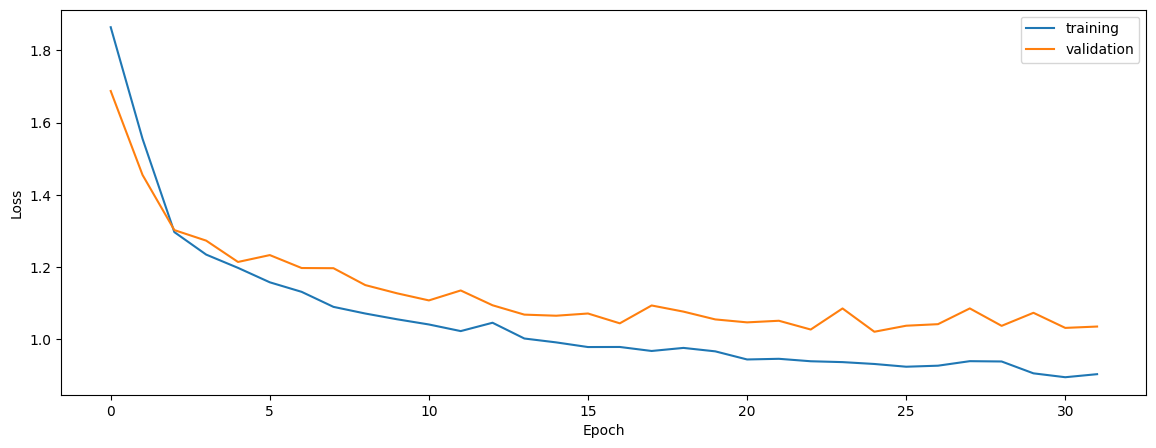

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['threshold'] = 0.6
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_MSE_7_1_0_1_1_0_e_e_0_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1160792, 828)
(1160792, 1)
validation
(184723, 828)
(184723, 1)
test
(137164, 828)
(137164, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_6 (Dense)             (None, 2048)              1697792   


 dense_7 (Dense)             (None, 1024)              2098176   


 dense_8 (Dense)             (None, 512)               524800    


 dense_9 (Dense)             (None, 256)               131328    


 dense_10 (Dense)            (None, 128)               32896     


 dense_11 (Dense)            (None, 1)                 129       


Total params: 4485121 (17.11 MB)


Trainable params: 4485121 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

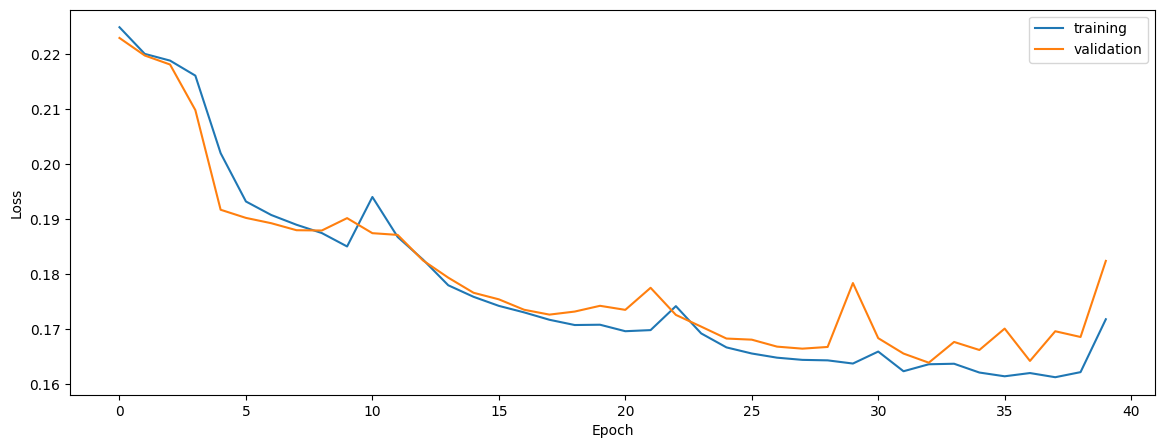

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['not_connected'] = True
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    not_connected = np.where(reg < threshold, 1, 0)
    not_connected = np.expand_dims(not_connected,-1)
    pred = np.concatenate([pred,not_connected],-1)
    for i in range(cla.shape[-1]):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

0.6024100306630839
0.5799002545586783
0.5519369969309167


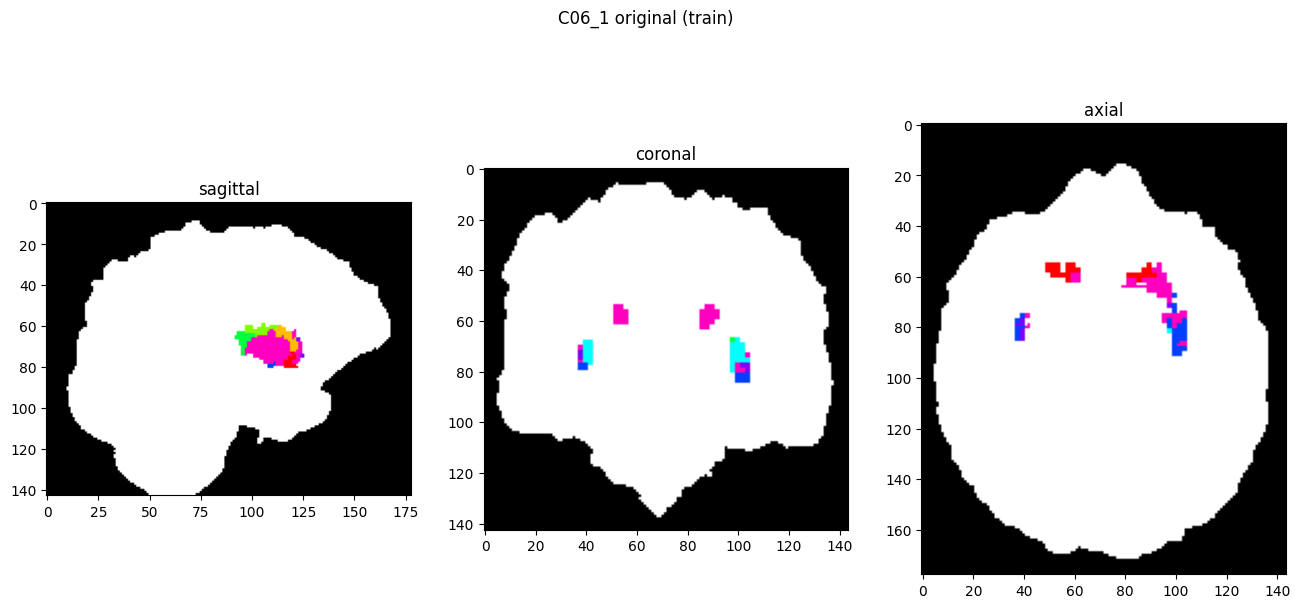

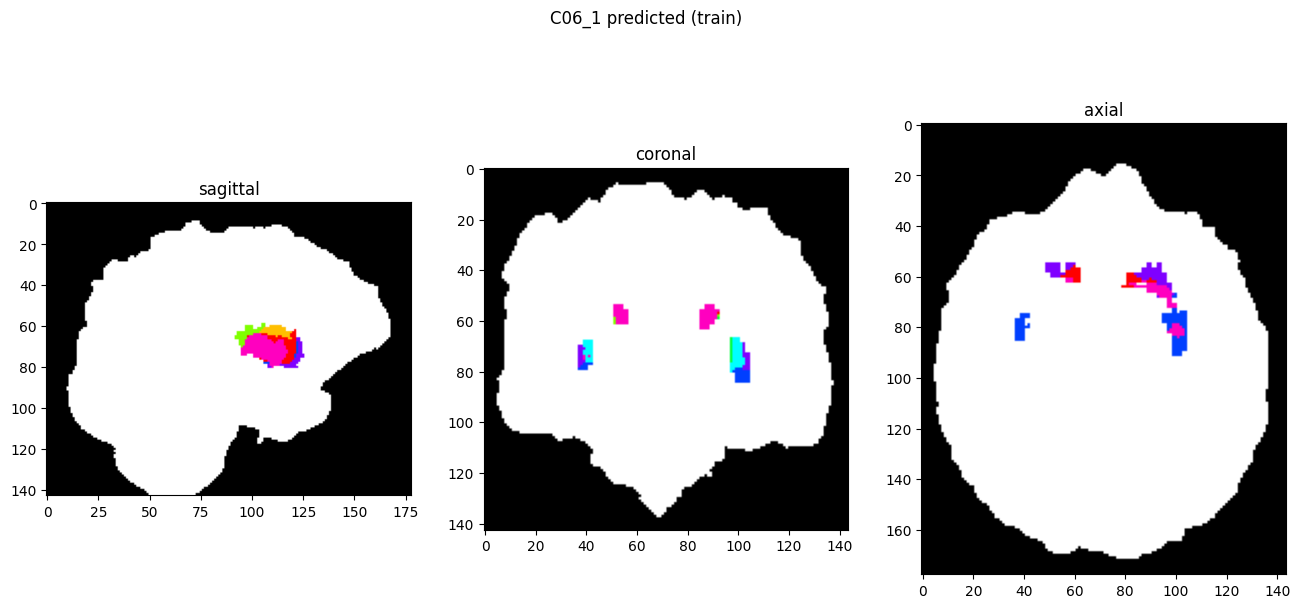

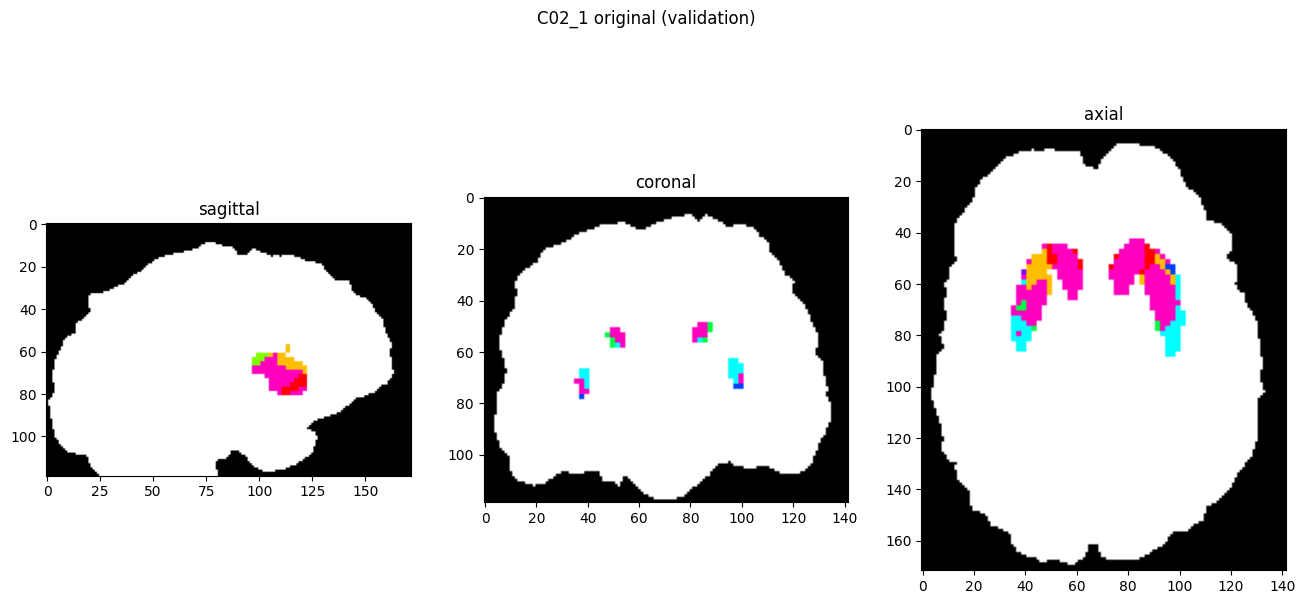

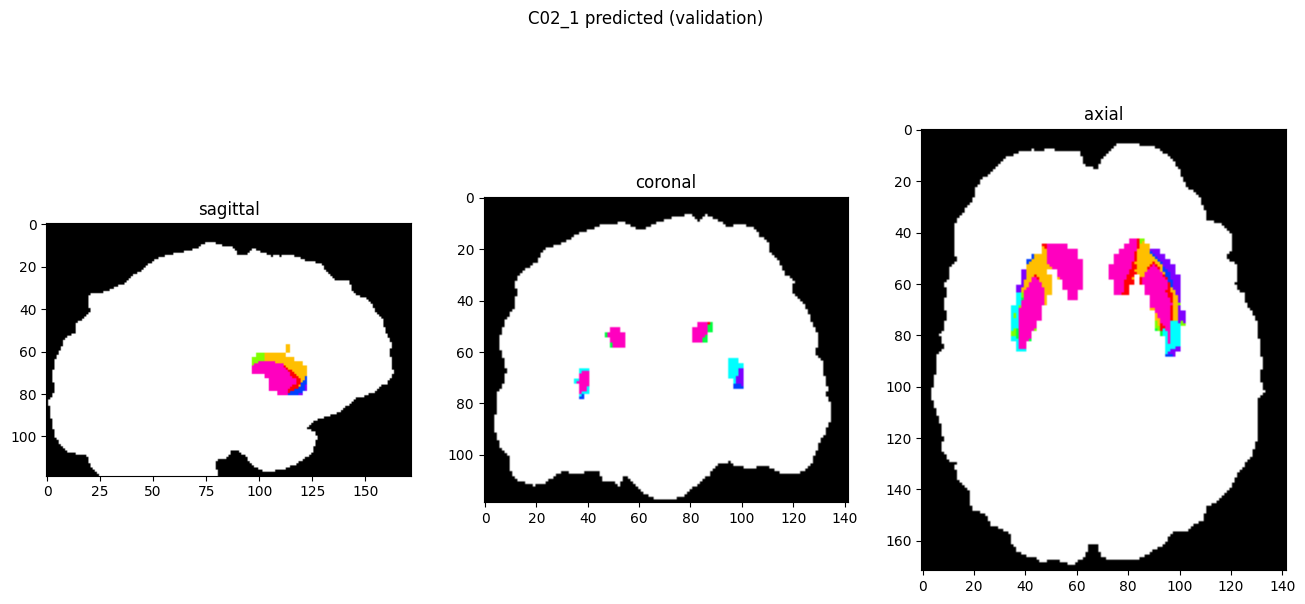

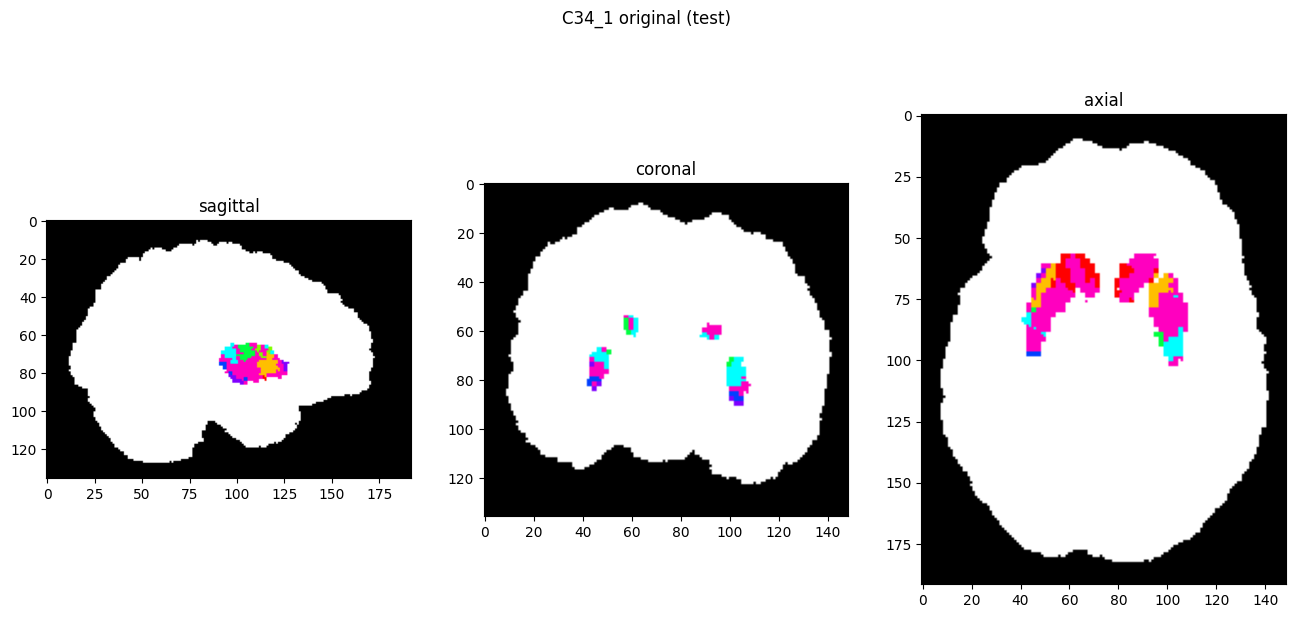

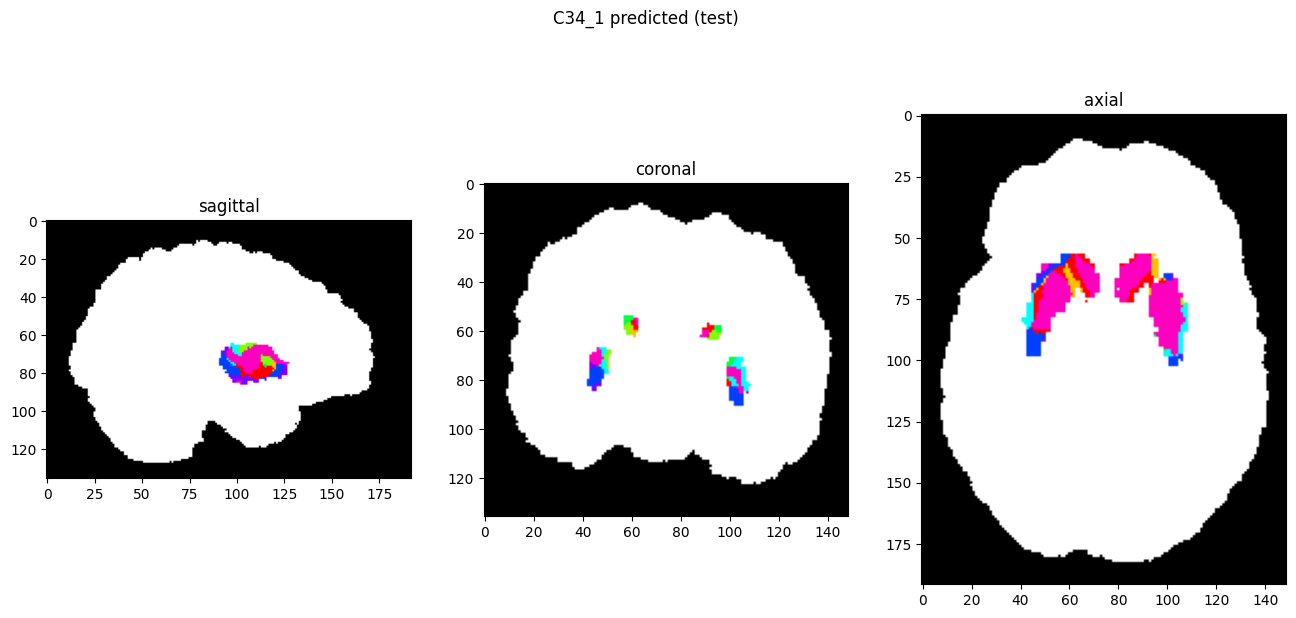

In [16]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)